
    
<font size="3"> This program includes 2 tasks:

<font size="3"> **Task 1: Data preparation and customer analytics**  
<font size="3"> **Task 2: Experimentation and uplift testing**

## Task 1: Data preparation and customer analytics

<font size="3"> **Background information**
    
<font size="3"> You are part of Quantium’s retail analytics team and have been approached by your client, the Category Manager for Chips, who wants to better understand the types of customers who purchase Chips and their purchasing behaviour within the region.
    
<font size="3"> The insights from your analysis will feed into the supermarket’s strategic plan for the chip category in the next half year.
    
<font size="3"> **Task**
    
<font size="3"> We need to present a strategic recommendation to Julia that is supported by data which she can then use for the upcoming category review however to do so we need to analyse the data to understand the current purchasing trends and behaviours. The client is particularly interested in customer segments and their chip purchasing behaviour. Consider what metrics would help describe the customers’ purchasing behaviour.

<font size="3"> To get started, download the resource csv data files below and begin performing high level data checks such as:

- <font size="3"> Creating and interpreting high level summaries of the data
- <font size="3"> Finding outliers and removing these (if applicable)
- <font size="3"> Checking data formats and correcting (if applicable)

<font size="3"> You will also want to derive extra features such as pack size and brand name from the data and define metrics of interest to enable you to draw insights on who spends on chips and what drives spends for each customer segment. Remember our end goal is to form a strategy based on the findings to provide a clear recommendation to Julia the Category Manager so make sure your insights can have a commercial application.

In [1]:
# load packages
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import re
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


<font size="4"> Load the data on transactions.

In [ ]:
# load data
transaction = pd.read_excel('/content/QVI_transaction_data (2).xlsx')
# make columns's names more interpretable
transaction = transaction.rename(columns={'STORE_NBR':'Store_number', 'LYLTY_CARD_NBR':'Card_number', 'TXN_ID':'Transaction_id',
                                          'PROD_NBR':'Product_number', 'PROD_NAME':'Product_name', 'PROD_QTY':'Product_quantity', 'TOT_SALES':'Total_sales'})
transaction.head(5)   #

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


<font size="3"> General information about the transaction dataset. The data type of some column are incorrect.

In [ ]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              264836 non-null  int64  
 1   Store_number      264836 non-null  int64  
 2   Card_number       264836 non-null  int64  
 3   Transaction_id    264836 non-null  int64  
 4   Product_number    264836 non-null  int64  
 5   Product_name      264836 non-null  object 
 6   Product_quantity  264836 non-null  int64  
 7   Total_sales       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


<font size="3"> Check duplicate rows and missing values.

In [ ]:
# define a function to display missing values and dupliate rows
def duplicate_and_missing(dataset, dataset_name):
    print('There are', dataset.shape[0], 'rows and', dataset.shape[1], 'columns in the dataset', '"'+dataset_name+'"','\n'+'--'*40)
    # display missing values
    if dataset.isna().sum().sum()!=0:  # if there is missing values
        missing_value = dataset.isna().sum()[dataset.isna().sum()!=0].to_frame(name='count')
        missing_value['proportion'] = missing_value['count']/len(dataset)
        print('There are', dataset.isna().sum().sum(), 'missing values')
        print(missing_value, '\n'+'--'*40)
    else:
        print('There is no missing value')
    # display duplicate rows
    if dataset.duplicated().sum()!=0:
        print('There are', dataset.duplicated().sum(), 'duplicate rows\n')
    else:
        print('There is no duplicate row\n')

<font size="3"> There is no missing value in the dataset. But there is 1 duplicate row. Let's find it.

In [ ]:
duplicate_and_missing(dataset=transaction, dataset_name='Transaction')

There are 264836 rows and 8 columns in the dataset "Transaction" 
--------------------------------------------------------------------------------
There is no missing value
There are 1 duplicate rows



<font size=3> Have a look at the duplicate rows.

In [ ]:
transaction[transaction.duplicated(keep=False)]

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales
124843,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0
124845,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


<font size="3"> Drop one of them. The number of rows decreases to 264835.

In [ ]:
transaction = transaction.drop_duplicates().reset_index(drop=True)
transaction.shape

(264835, 8)

<font size="3"> Convert column "DATE" to datetime data type.

In [ ]:
#
transaction['DATE'] = pd.to_datetime(transaction['DATE'], unit='D', origin=pd.Timestamp('1899-12-30'))
transaction = transaction.sort_values(by=['DATE']).reset_index(drop=True)   # sort by date
# a new feature only retaining year and month
transaction['Date'] = [i.strftime("%Y-%m") for i in transaction['DATE']]
transaction.head(5)

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Date
0,2018-07-01,116,116179,120232,81,Pringles Original Crisps 134g,2,7.4,2018-07
1,2018-07-01,226,226241,227506,34,Pringles Slt Vingar 134g,2,7.4,2018-07
2,2018-07-01,230,230210,233375,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,2018-07
3,2018-07-01,23,23145,19591,41,Doritos Salsa Mild 300g,2,5.2,2018-07
4,2018-07-01,63,63190,60625,61,Smiths Crinkle Cut Chips Chicken 170g,2,5.8,2018-07


<font size="3"> Create some new features

In [ ]:
# price
transaction['Product_price'] = np.round(transaction['Total_sales'] / transaction['Product_quantity'], 2)  # round to 2 decimal places.
# month, day of week
transaction['Month'] = transaction['DATE'].dt.month
transaction['Dayofweek'] = transaction['DATE'].dt.dayofweek.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

<font size="3"> **Finding 0.1: Some products have multiple prices. But this issue does not have an obvious impact on the tasks, so I will not handle this data issue.**

In [ ]:
unique_price = transaction.groupby(['Product_number','Product_price']).size().reset_index(name='count').groupby(['Product_number']).size()
unique_price[unique_price!=1].reset_index(name='Number of prices')

,Product_number,Number of prices
0,3,2
1,4,2
2,10,2
3,13,2
4,24,2
5,30,2
6,36,2
7,46,2
8,52,2
9,57,2


<font size="3"> We can see December only has 30 days. Let's find out which day is missing.

In [ ]:
month_day = transaction.groupby(['Month','DATE']).size().reset_index(name='count')
month_day.groupby(['Month']).size().reset_index(name='Number of days')

,Month,Number of days
0,1,31
1,2,28
2,3,31
3,4,30
4,5,31
5,6,30
6,7,31
7,8,31
8,9,30
9,10,31


<font size="3"> **Finding 0.2: All stores are closed on Christmas Day, so there is no records of "2018-12-25".**

In [ ]:
month_day[month_day['Month']==12][-8:-4]

,Month,DATE,count
356,12,2018-12-23,917
357,12,2018-12-24,939
358,12,2018-12-26,753
359,12,2018-12-27,732


<font size="3"> Process product names. First, remove the products which are not chips.

In [ ]:
# 'Old El Paso' is not a chip brand, remove them, the number of rows reduces from 264835 to 255511, 9324 rows are removed.
remove_index = [idx for idx in transaction.index if 'Old El Paso' in transaction.loc[idx, 'Product_name']]
transaction = transaction.drop(index=remove_index).reset_index(drop=True)
transaction.shape

(255511, 12)

<font size="3"> There are some non-character symbols, like " " (white space), "&" and "/", in the product names.

In [ ]:
non_character = []
for i in transaction['Product_name']:
    for j in re.findall(r'[^\w]', i):
        if j not in non_character:
            non_character.append(j)
non_character

[' ', '&', '/']

<font size="3"> Remove "&", "/" and unnecessary white spaces.

In [ ]:
product_names = transaction['Product_name']
product_name_clean = [re.sub(r'([\s&/]+)', ' ', name) for name in product_names]  # replace with a single space
transaction['Product_name'] = product_name_clean

<font size="3"> Extract pack size.

In [ ]:
# extract package size (weight)
product_weight = [re.findall(r'\d+\w', name)[0].lower() for name in product_name_clean]  # extract weight
product_name_short = []
# # remove weight from  product name
for i in range(len(product_weight)):
    product_name_short.append((re.sub(product_weight[i], '', product_name_clean[i])).strip())
transaction['Product_name_short'] = product_name_short
# only retain value of weight
product_weight = [re.findall(r'\d+', weight)[0].lower() for weight in product_weight]  # extract value
transaction['Product_weight'] = product_weight
transaction['Product_weight'] = transaction['Product_weight'].astype('int')
transaction['Total_product_weight'] = transaction['Product_weight'] * transaction['Product_quantity']
transaction.head(5)

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Date,Product_price,Month,Dayofweek,Product_name_short,Product_weight,Total_product_weight
0,2018-07-01,116,116179,120232,81,Pringles Original Crisps 134g,2,7.4,2018-07,3.7,7,Sunday,Pringles Original Crisps,134,268
1,2018-07-01,226,226241,227506,34,Pringles Slt Vingar 134g,2,7.4,2018-07,3.7,7,Sunday,Pringles Slt Vingar,134,268
2,2018-07-01,230,230210,233375,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,2018-07,4.2,7,Sunday,Tyrrells Crisps Lightly Salted,165,330
3,2018-07-01,23,23145,19591,41,Doritos Salsa Mild 300g,2,5.2,2018-07,2.6,7,Sunday,Doritos Salsa Mild,300,600
4,2018-07-01,63,63190,60625,61,Smiths Crinkle Cut Chips Chicken 170g,2,5.8,2018-07,2.9,7,Sunday,Smiths Crinkle Cut Chips Chicken,170,340


<font size="3"> Extract brand name.

In [ ]:
#
brand_list = ['Burger Rings', 'Cheetos', 'Cheezels', 'Cobs', 'CCs', 'Doritos', 'Dorito', 'French Fries', 'GrnWves', 'Grain Waves', 'Infzns', 'Infuzions', 'Kettle', 'NCC', 'Natural ChipCo',
              'Natural Chip Co', 'Pringles', 'RRD', 'Red Rock Deli', 'Smiths', 'Smith', 'Snbts', 'Sunbites', 'Thins', 'Tostitos', 'Twisties', 'Tyrrells', 'WW','Woolworths']
#
product_brand, product_flavour = [], []
for i in range(len(product_name_short)):
    short_name = product_name_short[i]
    for j in brand_list:
        if j in short_name:
            product_brand.append(j)
            product_flavour.append(re.sub(j, '', short_name).strip())   # remove space in the start and in the end of the string
            break
#
transaction['Product_brand'] = product_brand
transaction['Product_flavour'] = product_flavour
transaction.head(5)

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Date,Product_price,Month,Dayofweek,Product_name_short,Product_weight,Total_product_weight,Product_brand,Product_flavour
0,2018-07-01,116,116179,120232,81,Pringles Original Crisps 134g,2,7.4,2018-07,3.7,7,Sunday,Pringles Original Crisps,134,268,Pringles,Original Crisps
1,2018-07-01,226,226241,227506,34,Pringles Slt Vingar 134g,2,7.4,2018-07,3.7,7,Sunday,Pringles Slt Vingar,134,268,Pringles,Slt Vingar
2,2018-07-01,230,230210,233375,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,2018-07,4.2,7,Sunday,Tyrrells Crisps Lightly Salted,165,330,Tyrrells,Crisps Lightly Salted
3,2018-07-01,23,23145,19591,41,Doritos Salsa Mild 300g,2,5.2,2018-07,2.6,7,Sunday,Doritos Salsa Mild,300,600,Doritos,Salsa Mild
4,2018-07-01,63,63190,60625,61,Smiths Crinkle Cut Chips Chicken 170g,2,5.8,2018-07,2.9,7,Sunday,Smiths Crinkle Cut Chips Chicken,170,340,Smiths,Crinkle Cut Chips Chicken


<font size="3"> We can see some brand names are very similar, like Smiths and Smith. Actually, they are the same brand.

In [ ]:
transaction['Product_brand'].unique()

array(['Pringles', 'Tyrrells', 'Doritos', 'Smiths', 'Kettle', 'Smith',
       'Thins', 'Grain Waves', 'Woolworths', 'Infuzions', 'Tostitos',
       'Red Rock Deli', 'Cobs', 'Twisties', 'French Fries', 'RRD', 'WW',
       'Cheezels', 'Dorito', 'CCs', 'GrnWves', 'Infzns',
       'Natural Chip Co', 'NCC', 'Natural ChipCo', 'Cheetos', 'Snbts',
       'Burger Rings', 'Sunbites'], dtype=object)

<font size="3"> Correct the inconsistent brand names.

In [ ]:
#
transaction['Product_brand'] = np.where(transaction['Product_brand']=='Dorito', 'Doritos', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='GrnWves', 'Grain Waves', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='Infzns', 'Infuzions', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='Natural ChipCo', 'Natural Chip Co', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='NCC', 'Natural Chip Co', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='RRD', 'Red Rock Deli', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='Smith', 'Smiths', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='Snbts', 'Sunbites', transaction['Product_brand'])
transaction['Product_brand'] = np.where(transaction['Product_brand']=='WW', 'Woolworths', transaction['Product_brand'])

<font size="3"> Create the correct product name.

In [ ]:
transaction['Product_Name'] = transaction['Product_brand'] + ' ' + transaction['Product_flavour'] + ' ' + transaction['Product_weight'].astype('str') + 'g'
transaction = transaction.drop(columns=['Product_name_short'])
transaction.head(5)

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Date,Product_price,Month,Dayofweek,Product_weight,Total_product_weight,Product_brand,Product_flavour,Product_Name
0,2018-07-01,116,116179,120232,81,Pringles Original Crisps 134g,2,7.4,2018-07,3.7,7,Sunday,134,268,Pringles,Original Crisps,Pringles Original Crisps 134g
1,2018-07-01,226,226241,227506,34,Pringles Slt Vingar 134g,2,7.4,2018-07,3.7,7,Sunday,134,268,Pringles,Slt Vingar,Pringles Slt Vingar 134g
2,2018-07-01,230,230210,233375,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,2018-07,4.2,7,Sunday,165,330,Tyrrells,Crisps Lightly Salted,Tyrrells Crisps Lightly Salted 165g
3,2018-07-01,23,23145,19591,41,Doritos Salsa Mild 300g,2,5.2,2018-07,2.6,7,Sunday,300,600,Doritos,Salsa Mild,Doritos Salsa Mild 300g
4,2018-07-01,63,63190,60625,61,Smiths Crinkle Cut Chips Chicken 170g,2,5.8,2018-07,2.9,7,Sunday,170,340,Smiths,Crinkle Cut Chips Chicken,Smiths Crinkle Cut Chips Chicken 170g


<font size="3"> Some Woolworths products are not chips, remove them. The number of rows reduces from 255511 to 252590, 2921 rows are removed.

In [ ]:
#
non_chip_name = ['Woolworths Medium Salsa 300g','Woolworths Mild Salsa 300g']
transaction = transaction[~transaction['Product_Name'].isin(non_chip_name)].reset_index(drop=True)
transaction.shape

(252590, 17)

<font size="3"> Check consistency of features' values.

In [ ]:
#
def describe_categorical(dataset):
    cat_columns = dataset.dtypes[dataset.dtypes=='object'].index.tolist()
    if len(cat_columns)!=0:
        print('Categorical variables are', cat_columns,'\n'+'=='*40)
        for cat in cat_columns:
            describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
            describe_frame['proportion'] = describe_frame['count']/len(dataset)
            print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
    else:
        print('There is no categorical variables in the dataset')

<font size="3"> It looks there is no consistency issue.

In [ ]:
describe_categorical(dataset=transaction)

Categorical variables are ['Product_name', 'Date', 'Dayofweek', 'Product_brand', 'Product_flavour', 'Product_Name'] 
                                 Product_name  count  proportion
0          Kettle Mozzarella Basil Pesto 175g   3304    0.013080
1    Kettle Tortilla ChpsHny Jlpno Chili 150g   3296    0.013049
2     Cobs Popd Swt Chlli Sr Cream Chips 110g   3269    0.012942
3            Tyrrells Crisps Ched Chives 165g   3268    0.012938
4               Cobs Popd Sea Salt Chips 110g   3265    0.012926
..                                        ...    ...         ...
104     Sunbites Whlegrn Crisps Frch Onin 90g   1432    0.005669
105                      RRD Pc Sea Salt 165g   1431    0.005665
106         NCC Sour Cream Garden Chives 175g   1419    0.005618
107            French Fries Potato Chips 175g   1418    0.005614
108              WW Crinkle Cut Original 175g   1410    0.005582

[109 rows x 3 columns] 
------------------------------------------------------------------------------

<font size="3"> Check numeric features.

In [ ]:
# dataset: a pandas dataframe;
def describe_numeric(dataset):
    # for numeric columns whose values are discrete, display values and their frequency
    int_columns = dataset.dtypes[dataset.dtypes=='int'].index.tolist()
    # for numeric columns whose values are continuous, plot their value distribution
    float_columns = dataset.dtypes[dataset.dtypes=='float'].index.tolist()
    if len(int_columns)+len(float_columns)!=0:
        print('Numeric variables are', int_columns+float_columns,'\n'+'=='*40)
        # integer numeric feature
        if len(int_columns)!=0:
            for cat in int_columns:
                describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
                describe_frame['proportion'] = describe_frame['count']/len(dataset)
                print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
        #
        print(dataset[int_columns + float_columns].describe().loc[['min','max','mean','50%']].T.rename(columns={'50%':'median'}), '\n'+'--'*40)
    else:
        print('There is no numeric variables in the dataset')

<font size="3"> 71734 customers completed 251037 transactions purchasing 109 kinds of chips from 272 stores.

In [ ]:
describe_numeric(dataset=transaction)

Numeric variables are ['Store_number', 'Card_number', 'Transaction_id', 'Product_number', 'Product_quantity', 'Month', 'Product_weight', 'Total_product_weight', 'Total_sales', 'Product_price'] 
     Store_number  count  proportion
0             226   1918    0.007593
1              88   1786    0.007071
2              93   1753    0.006940
3             165   1741    0.006893
4             237   1714    0.006786
..            ...    ...         ...
267           211      2    0.000008
268           206      2    0.000008
269            11      2    0.000008
270            92      1    0.000004
271            76      1    0.000004

[272 rows x 3 columns] 
--------------------------------------------------------------------------------
       Card_number  count  proportion
0           162039     18    0.000071
1           116181     17    0.000067
2           230078     17    0.000067
3           222242     16    0.000063
4           109036     16    0.000063
...            ...    ...   

<font size="3"> Check outlier points.
    
<font size="3"> There are outlier points in "Product_quantity".

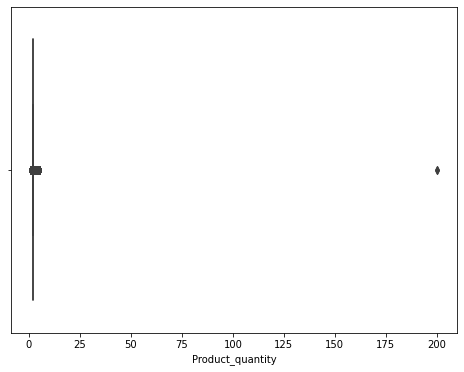

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = sns.boxplot(data=transaction, x='Product_quantity')

<font size="3"> **Finding 0.3: There are two transactions purchasing 200 packs of chips each. Also, this customer only had these two transactions. So, we can assume this customer was more likely to be an organization rather than a single person. It is better to remove it from the dataset.**

In [ ]:
# only one customer
transaction[transaction['Product_quantity']>150]

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Date,Product_price,Month,Dayofweek,Product_weight,Total_product_weight,Product_brand,Product_flavour,Product_Name
34044,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,2018-08,3.25,8,Sunday,380,76000,Doritos,Corn Chp Supreme,Doritos Corn Chp Supreme 380g
223810,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,2019-05,3.25,5,Monday,380,76000,Doritos,Corn Chp Supreme,Doritos Corn Chp Supreme 380g


In [ ]:
# only two transactions
transaction[transaction['Card_number']==226000]

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Date,Product_price,Month,Dayofweek,Product_weight,Total_product_weight,Product_brand,Product_flavour,Product_Name
34044,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,2018-08,3.25,8,Sunday,380,76000,Doritos,Corn Chp Supreme,Doritos Corn Chp Supreme 380g
223810,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,2019-05,3.25,5,Monday,380,76000,Doritos,Corn Chp Supreme,Doritos Corn Chp Supreme 380g


<font size="3"> Remove this customer. The number of rows reduces from 252590 to 252588.

In [ ]:
transaction = transaction[transaction['Product_quantity']<150].reset_index(drop=True)
transaction.shape

(252588, 17)

<font size="3"> The whole period of transactions ranges from 2018-07-01 to 2019-06-30, a whole year (no reocrd of "2018-12-25").

In [ ]:
transaction[transaction.dtypes[transaction.dtypes=='datetime64[ns]'].index.tolist()].describe(datetime_is_numeric=True)

,DATE
count,252588
mean,2018-12-30 01:46:29.662216448
min,2018-07-01 00:00:00
25%,2018-09-30 00:00:00
50%,2018-12-30 00:00:00
75%,2019-03-31 00:00:00
max,2019-06-30 00:00:00


<font size=4> Let's have a look at the dataset about purchase behaviours.

In [ ]:
behaviour = pd.read_csv('../input/quantiuminternshipprogram/QVI_purchase_behaviour.csv')
behaviour = behaviour.rename(columns={'LYLTY_CARD_NBR':'Card_number'})
behaviour.head(5)

,Card_number,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


<font size="3"> Check consistency of categorical features. No issue is found.

In [ ]:
describe_categorical(dataset=behaviour)

Categorical variables are ['LIFESTAGE', 'PREMIUM_CUSTOMER'] 
                LIFESTAGE  count  proportion
0                RETIREES  14805    0.203822
1   OLDER SINGLES/COUPLES  14609    0.201123
2   YOUNG SINGLES/COUPLES  14441    0.198811
3          OLDER FAMILIES   9780    0.134642
4          YOUNG FAMILIES   9178    0.126354
5  MIDAGE SINGLES/COUPLES   7275    0.100156
6            NEW FAMILIES   2549    0.035092 
--------------------------------------------------------------------------------
  PREMIUM_CUSTOMER  count  proportion
0       Mainstream  29245    0.402619
1           Budget  24470    0.336881
2          Premium  18922    0.260501 
--------------------------------------------------------------------------------


<font size=4> Let's get some insights from the purchase behaviour dataset.

In [ ]:
# define a funtion to add value to a bar chart.
def add_value_to_barchart(ax,    # ax is a plot object.
                          if_vertical=True,    # if it is a vertical bar chart. If False, a horizontal bar chart
                          gap_between_value_bar=0,   # space between the value and the top of bar, default: on space
                          if_value=True,   # if display bar height (value)
                          if_value_int=False,    # if display bar height in the format of integers, only valid when if_value=True
                          value_decimal=2,    # decimal place of value, only valid when if_value_int=False
                          if_percentage=False,    # if display proportion of bar height to the sum of all bar heights
                          percentage_decimal=2,    # decimal place of proportion, only valid when if_percentage=True
                          gap_between_value_percentage=0,     # space between the value and proportion value, only valid when if_value=True and if_percentage=True
                          ymargin=0.1,     # only valid when if_vertical=True, padding added to each limit of y-axis
                          xmargin=0.15,     # only valid when if_vertical=False, padding added to each limit of x-axis
                          ):
    if if_vertical:    # a vertical bar chart
        # calculate total value
        total_value = np.sum([p.get_height() for p in ax.patches])
        #
        for p in ax.patches:
            # location parameter
            x = p.get_x() + p.get_width()/2
            if p.get_height()>=0:
                y1 = p.get_height() + gap_between_value_bar
                y2 = y1 + gap_between_value_percentage
            else:
                y1 = p.get_height() - gap_between_value_bar*3
                y2 = y1 - gap_between_value_percentage*3
            # only display value
            if if_value and if_percentage==False:
                if if_value_int:     # display integer value
                    value = int(p.get_height())
                else:
                    value = round(p.get_height(), value_decimal)   # display float point value
                ax.annotate(text=value, xy=(x, y1), ha='center')
            # display value and proportion
            elif if_value and if_percentage==True:
                if if_value_int:     # display integer value
                    value = int(p.get_height())
                else:
                    value = round(p.get_height(), value_decimal)   # display float point value
                percentage = round(p.get_height()/total_value*100, percentage_decimal)
                ax.annotate(text=value, xy=(x, y2), ha='center')
                ax.annotate(text=f'({percentage}%)', xy=(x, y1), ha='center')
            # only display proportion
            elif if_value==False and if_percentage==True:
                percentage = round(p.get_height()/total_value*100, percentage_decimal)
                ax.annotate(text=f'{percentage}%', xy=(x, y1), ha='center')
        ax.margins(y=ymargin)
    # a horizontal bar chart
    else:
        # calculate total value
        total_value = np.sum([p.get_width() for p in ax.patches])
        #
        for p in ax.patches:
            # location parameter
            x = p.get_width() + gap_between_value_bar
            y = p.get_y() + p.get_height()*0.6
            y1 = p.get_y() + p.get_height()*0.4
            y2 = y1 + gap_between_value_percentage
            # only display value
            if if_value and if_percentage==False:
                if if_value_int:     # display integer value
                    value = int(p.get_width())
                else:
                    value = round(p.get_width(), value_decimal)   # display float point value
                ax.annotate(text=value, xy=(x, y), ha='center')
            # display value and proportion
            elif if_value and if_percentage==True:
                if if_value_int:     # display integer value
                    value = int(p.get_width())
                else:
                    value = round(p.get_width(), value_decimal)   # display float point value
                percentage = round(p.get_width()/total_value*100, percentage_decimal)
                ax.annotate(text=value, xy=(x, y1), ha='center')
                ax.annotate(text=f'({percentage}%)', xy=(x, y2), ha='center')
            # only display proportion
            elif if_value==False and if_percentage==True:
                percentage = round(p.get_width()/total_value*100, percentage_decimal)
                ax.annotate(text=f'{percentage}%', xy=(x, y), ha='center')
        ax.margins(x=xmargin)

<font size=3> **Findsing 1.1: As each month has different days, the monthly sales volume and average daily sales volume by month may follow different patterns. From the bar charts below, we can see they do follow different patterns.**

- **<font size=3> The monthly sales volume reaches peak in December and lowest points in February.**
- **<font size=3> Cutomers bought more chips in December, but fewer in May and August.**
- **<font size=3> The total sales has very similar patterns to the sales volume.**

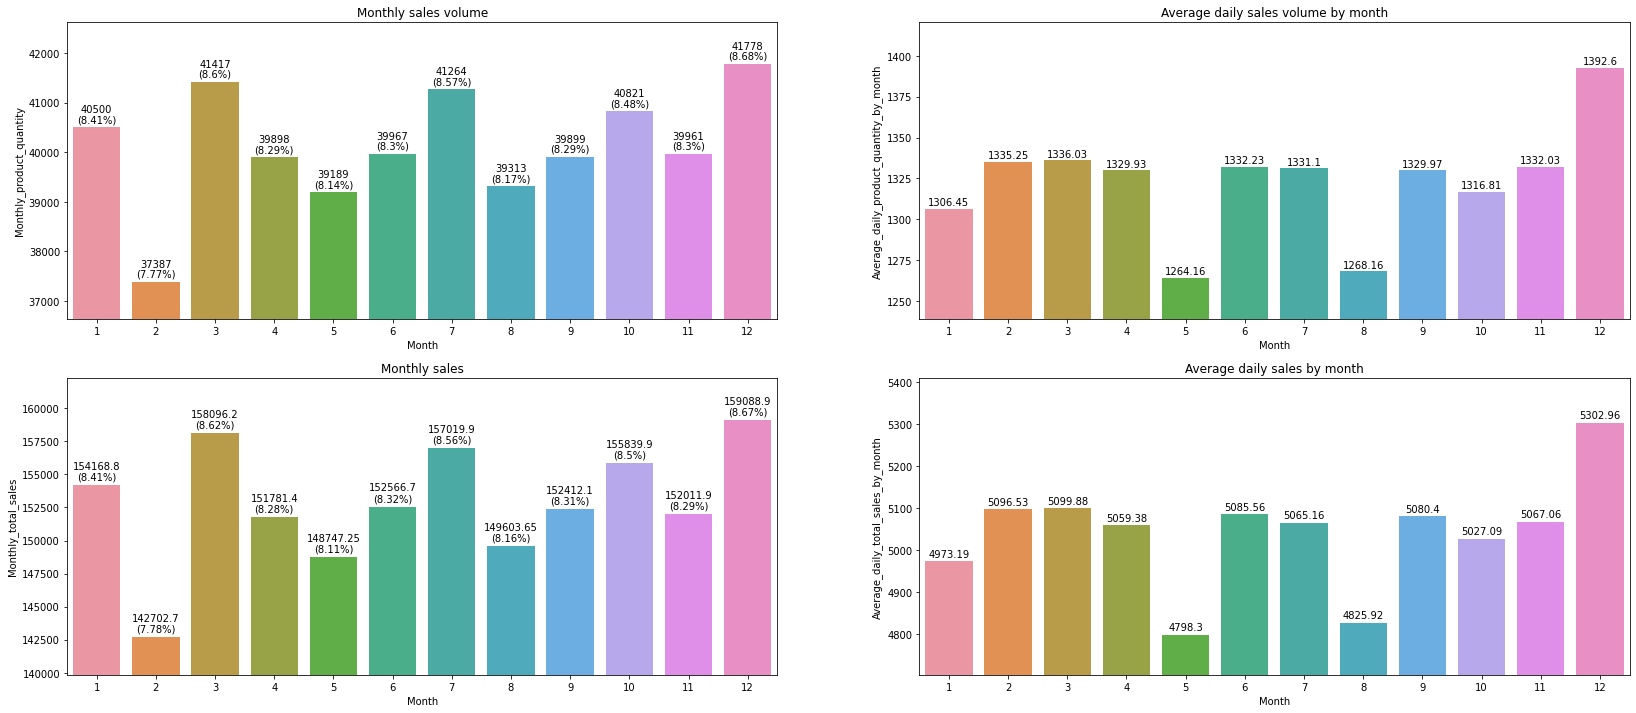

In [ ]:
# Create a figure
fig = plt.figure(figsize=(28, 12))
# Monthly sales volume
monthly_product_quantity = transaction.groupby(['Month']).sum()['Product_quantity'].reset_index(name='Monthly_product_quantity')
#
fig.add_subplot(2, 2, 1)
ax = sns.barplot(data=monthly_product_quantity, x='Month', y='Monthly_product_quantity')
add_value_to_barchart(ax=ax, gap_between_value_bar=100, if_value_int=True, if_percentage=True, gap_between_value_percentage=200)
plt.ylim(monthly_product_quantity['Monthly_product_quantity'].min()*0.98, monthly_product_quantity['Monthly_product_quantity'].max()*1.02)
plt.title('Monthly sales volume')
# Average daily sales volume
daily_product_quantity = transaction.groupby(['Month','DATE']).sum()['Product_quantity'].reset_index(name='Daily_product_quantity')
average_daily_product_quantity_by_month = daily_product_quantity.groupby(['Month']).mean()['Daily_product_quantity'].reset_index(name='Average_daily_product_quantity_by_month')
average_daily_product_quantity_by_month['Average_daily_product_quantity_by_month'] = np.round(average_daily_product_quantity_by_month['Average_daily_product_quantity_by_month'], 2)
#
fig.add_subplot(2, 2, 2)
ax = sns.barplot(data=average_daily_product_quantity_by_month, x='Month', y='Average_daily_product_quantity_by_month')
add_value_to_barchart(ax=ax, gap_between_value_bar=2, if_percentage=False)
plt.ylim(average_daily_product_quantity_by_month['Average_daily_product_quantity_by_month'].min()*0.98, average_daily_product_quantity_by_month['Average_daily_product_quantity_by_month'].max()*1.02)
plt.title('Average daily sales volume by month')
# Monthly sales
monthly_total_sales = transaction.groupby(['Month']).sum()['Total_sales'].reset_index(name='Monthly_total_sales')
#
fig.add_subplot(2, 2, 3)
ax = sns.barplot(data=monthly_total_sales, x='Month', y='Monthly_total_sales')
add_value_to_barchart(ax=ax, gap_between_value_bar=400, if_percentage=True, gap_between_value_percentage=800)
plt.ylim(monthly_total_sales['Monthly_total_sales'].min()*0.98, monthly_total_sales['Monthly_total_sales'].max()*1.02)
plt.title('Monthly sales')
# Average daily sales
daily_total_sales = transaction.groupby(['Month','DATE']).sum()['Total_sales'].reset_index(name='Daily_total_sales')
average_daily_total_sales_by_month = daily_total_sales.groupby(['Month']).mean()['Daily_total_sales'].reset_index(name='Average_daily_total_sales_by_month')
average_daily_total_sales_by_month['Average_daily_total_sales_by_month'] = np.round(average_daily_total_sales_by_month['Average_daily_total_sales_by_month'], 2)
#
fig.add_subplot(2, 2, 4)
ax = sns.barplot(data=average_daily_total_sales_by_month, x='Month', y='Average_daily_total_sales_by_month')
add_value_to_barchart(ax=ax, gap_between_value_bar=10, if_percentage=False)
plt.ylim(average_daily_total_sales_by_month['Average_daily_total_sales_by_month'].min()*0.98, average_daily_total_sales_by_month['Average_daily_total_sales_by_month'].max()*1.02)
plt.title('Average daily sales by month')
plt.show()

**<font size=3> Finding 1.2**
- **<font size=3> Customers bought most chips on Thursdays and fewest on Wednesdays.**
- **<font size=3> Sales revenue displays the same pattern as sales volume.**

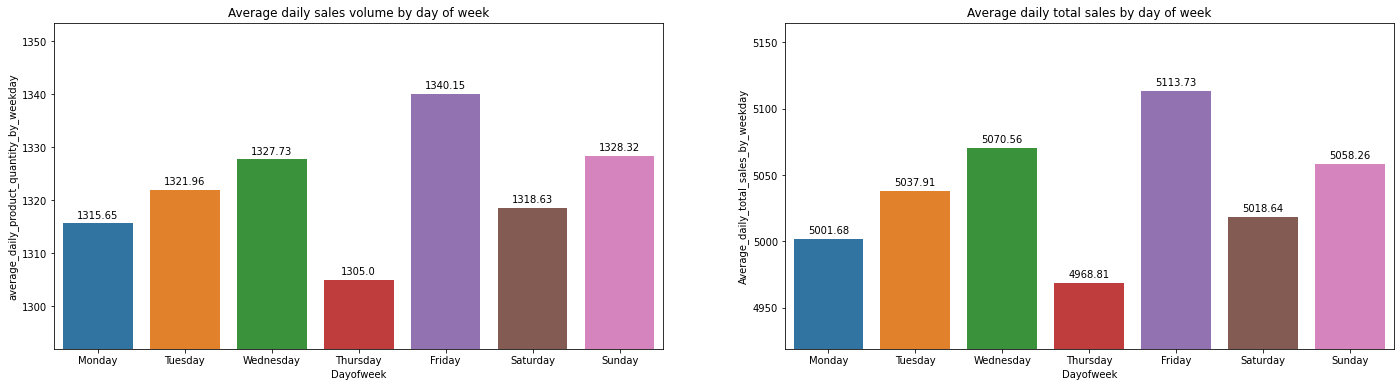

In [ ]:
# Create a figure
fig = plt.figure(figsize=(24, 6))
display_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# average daily sales volume
daily_product_quantity_by_weekday = transaction.groupby(['Dayofweek','DATE']).sum()['Product_quantity'].reset_index(name='daily_product_quantity_by_weekday')
average_daily_product_quantity_by_weekday = daily_product_quantity_by_weekday.groupby(['Dayofweek']).mean()['daily_product_quantity_by_weekday'].reset_index(name='average_daily_product_quantity_by_weekday')
average_daily_product_quantity_by_weekday['average_daily_product_quantity_by_weekday'] = np.round(average_daily_product_quantity_by_weekday['average_daily_product_quantity_by_weekday'], 2)
#
fig.add_subplot(1, 2, 1)
ax = sns.barplot(data=average_daily_product_quantity_by_weekday, x='Dayofweek', y='average_daily_product_quantity_by_weekday', order=display_order)
add_value_to_barchart(ax=ax, gap_between_value_bar=1)
plt.ylim(average_daily_product_quantity_by_weekday['average_daily_product_quantity_by_weekday'].min()*0.99, average_daily_product_quantity_by_weekday['average_daily_product_quantity_by_weekday'].max()*1.01)
plt.title('Average daily sales volume by day of week')
# average daily sales
daily_total_sales = transaction.groupby(['Dayofweek','DATE']).sum()['Total_sales'].reset_index(name='Daily_total_sales')
average_daily_total_sales_by_weekday = daily_total_sales.groupby(['Dayofweek']).mean()['Daily_total_sales'].reset_index(name='Average_daily_total_sales_by_weekday')
average_daily_total_sales_by_weekday['Average_daily_total_sales_by_weekday'] = np.round(average_daily_total_sales_by_weekday['Average_daily_total_sales_by_weekday'], 2)
#
fig.add_subplot(1, 2, 2)
ax = sns.barplot(data=average_daily_total_sales_by_weekday, x='Dayofweek', y='Average_daily_total_sales_by_weekday', order=display_order)
add_value_to_barchart(ax=ax, gap_between_value_bar=4)
plt.ylim(average_daily_total_sales_by_weekday['Average_daily_total_sales_by_weekday'].min()*0.99, average_daily_total_sales_by_weekday['Average_daily_total_sales_by_weekday'].max()*1.01)
plt.title('Average daily total sales by day of week')
plt.show()

In [ ]:
# define a funtion to add percent values in a vertical chart only showing top N items.
def add_top_n_value_to_vertical_barchart(ax, total_value, gap_between_value_bar, gap_between_value_percentage=0, if_int=False):
    for p in ax.patches:
        if if_int:
            value = int(p.get_height())
        else:
            value = p.get_height()
        percentage = '({:.2f}%)'.format(value/total_value*100)
        x = p.get_x() + p.get_width()/2
        y1 = p.get_height() + gap_between_value_bar
        y2 = y1 + gap_between_value_percentage
        ax.annotate(text=value, xy=(x, y2), ha='center')
        ax.annotate(text=percentage, xy=(x, y1), ha='center')
    ax.margins(y=0.1)

# define a funtion to add percent values in a horizontal chart only showing top N items.
def add_top_n_value_to_horizontal_barchart(ax, total_value, gap_between_value_bar, gap_between_value_percentage=0, if_int=False):
    for p in ax.patches:
        if if_int:
            value = int(p.get_width())
        else:
            value = p.get_width()
        percentage = '({:.2f}%)'.format(value/total_value*100)
        y1 = p.get_y() + p.get_height()*0.4
        y2 = y1 + gap_between_value_percentage
        x = p.get_width() + gap_between_value_bar
        ax.annotate(text=value, xy=(x, y1), ha='center')
        ax.annotate(text=percentage, xy=(x, y2), ha='center')
    ax.margins(x=0.1)

# define a function to only display the top N items by sales volume and sales revenue
def display_top_barchart(feature_name, top, sales_volume_range=None, sales_range=None, title=None, if_horizontal=False, figsize=(16,6),
                         gap_between_value_bar_volume=0, gap_between_value_percentage_volume=0, gap_between_value_bar_sales=0, gap_between_value_percentage_sales=0):
    # create a figure
    fig = plt.figure(figsize=figsize)
    # sales volume
    product_quantity_ = transaction.groupby([feature_name]).sum()['Product_quantity'].reset_index(name=f'Product_quantity_by_{feature_name}')
    product_quantity_ = product_quantity_.sort_values(by=[f'Product_quantity_by_{feature_name}'], ascending=False)
    # plot
    fig.add_subplot(1, 2, 1)
    # plot vertical bar chart
    if not if_horizontal:
        ax = sns.barplot(data=product_quantity_, x=feature_name, y=f'Product_quantity_by_{feature_name}', order=product_quantity_[feature_name][:top])
        # show value and percentage
        add_top_n_value_to_vertical_barchart(ax=ax, total_value=transaction['Product_quantity'].sum(), if_int=True,
                                             gap_between_value_bar=gap_between_value_bar_volume, gap_between_value_percentage=gap_between_value_percentage_volume)
        plt.ylim(sales_volume_range)
    else:
        # plot horizontal bar chart due to the long feature values, for example, chips brand name.
        ax = sns.barplot(data=product_quantity_, y=feature_name, x=f'Product_quantity_by_{feature_name}', order=product_quantity_[feature_name][:top])
        # show value and percentage
        add_top_n_value_to_horizontal_barchart(ax=ax, total_value=transaction['Product_quantity'].sum(), if_int=True,
                                               gap_between_value_bar=gap_between_value_bar_volume, gap_between_value_percentage=gap_between_value_percentage_volume)
        plt.xlim(sales_volume_range)
    plt.title(f'Top {top} {title} with the highest sales volume')

    # sales revenue
    total_sales_ = transaction.groupby([feature_name]).sum()['Total_sales'].reset_index(name=f'Total_sales_by_{feature_name}')
    total_sales_ = total_sales_.sort_values(by=[f'Total_sales_by_{feature_name}'], ascending=False)
    total_sales_[f'Total_sales_by_{feature_name}'] = np.round(total_sales_[f'Total_sales_by_{feature_name}'], 2)
    # plot
    fig.add_subplot(1, 2, 2)
    # plot vertical bar chart
    if not if_horizontal:
        ax = sns.barplot(data=total_sales_, x=feature_name, y=f'Total_sales_by_{feature_name}', order=total_sales_[feature_name][:top])
        # show value and percentage
        add_top_n_value_to_vertical_barchart(ax=ax, total_value=transaction['Total_sales'].sum(),
                                             gap_between_value_bar=gap_between_value_bar_sales, gap_between_value_percentage=gap_between_value_percentage_sales)
        plt.ylim(sales_range)
    else:
        ax = sns.barplot(data=total_sales_, y=feature_name, x=f'Total_sales_by_{feature_name}', order=total_sales_[feature_name][:top])
        # show value and percentage
        add_top_n_value_to_horizontal_barchart(ax=ax, total_value=transaction['Total_sales'].sum(),
                                             gap_between_value_bar=gap_between_value_bar_sales, gap_between_value_percentage=gap_between_value_percentage_sales)
        plt.xlim(sales_range)
    plt.title(f'Top {top} {title} with the highest sales')
    plt.show()

<font size=3> **Finding 1.3: popular store**
 - <font size=3> **Store 226 had the highest sales volume and sales revenue.**

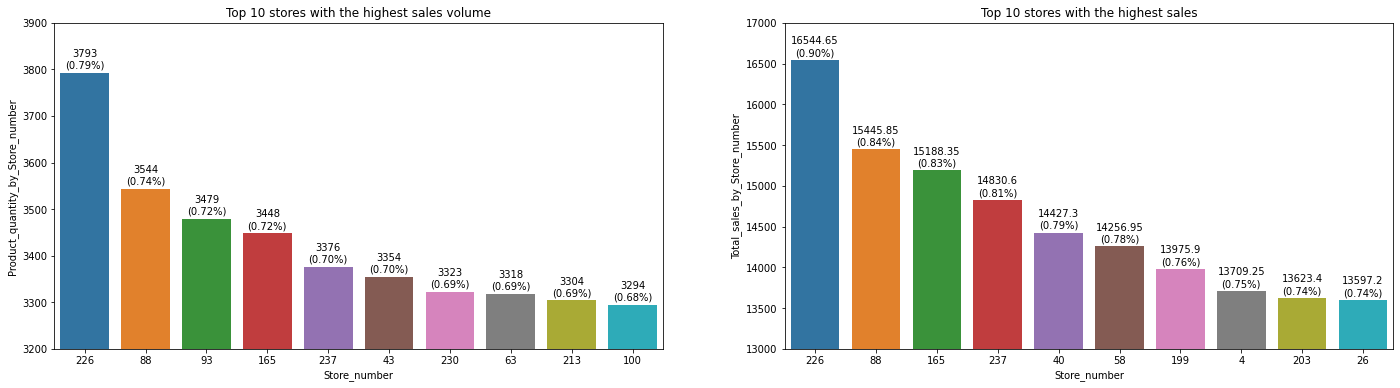

In [ ]:
display_top_barchart(feature_name='Store_number', top=10, sales_volume_range=(3200,3900), sales_range=(13000,17000), title='stores', if_horizontal=False, figsize=(24,6),
                     gap_between_value_bar_volume=10, gap_between_value_percentage_volume=25, gap_between_value_bar_sales=50, gap_between_value_percentage_sales=150)

<font size=3> **Finding 1.4: popular chips**
- <font size=3> **Kettle Mozzarella Basil Pesto 175g (product number is 102) was the most popular chips.**
- <font size=3> **Dorito Corn Chp Supreme 380g (product number is 4) brought highest sales revenue.**

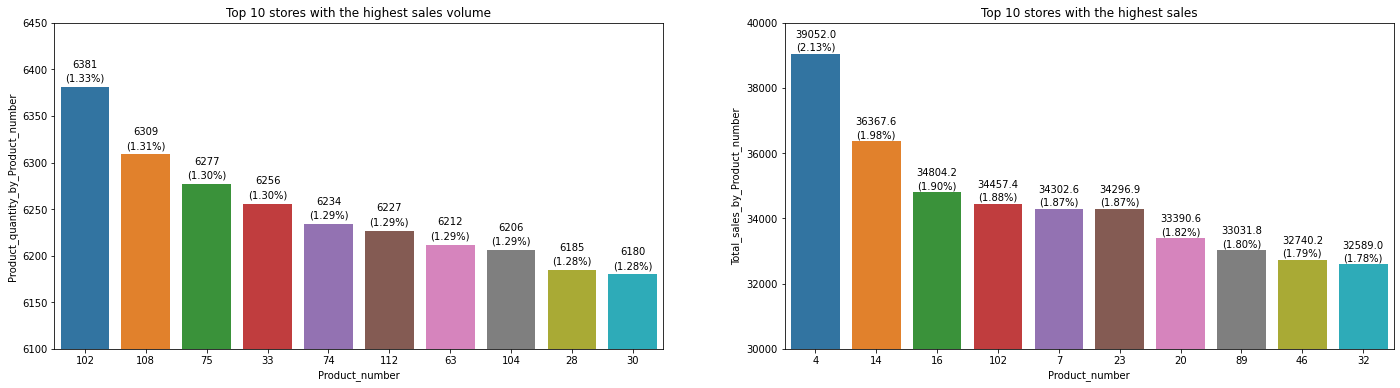

In [ ]:
display_top_barchart(feature_name='Product_number', top=10, sales_volume_range=(6100, 6450), sales_range=(30000,40000), title='stores', if_horizontal=False, figsize=(24,6),
                     gap_between_value_bar_volume=6, gap_between_value_percentage_volume=15, gap_between_value_bar_sales=100, gap_between_value_percentage_sales=400)

In [ ]:
transaction[transaction['Product_number']==102].head(1)[['Product_number','Product_Name']]

,Product_number,Product_Name
30,102,Kettle Mozzarella Basil Pesto 175g


In [ ]:
transaction[transaction['Product_number']==4].head(1)[['Product_number','Product_Name']]

,Product_number,Product_Name
52,4,Doritos Corn Chp Supreme 380g


<font size=3> **Finding 1.5: popular chips brand**
- <font size=3> **Kettle chips were the most popular chips.**

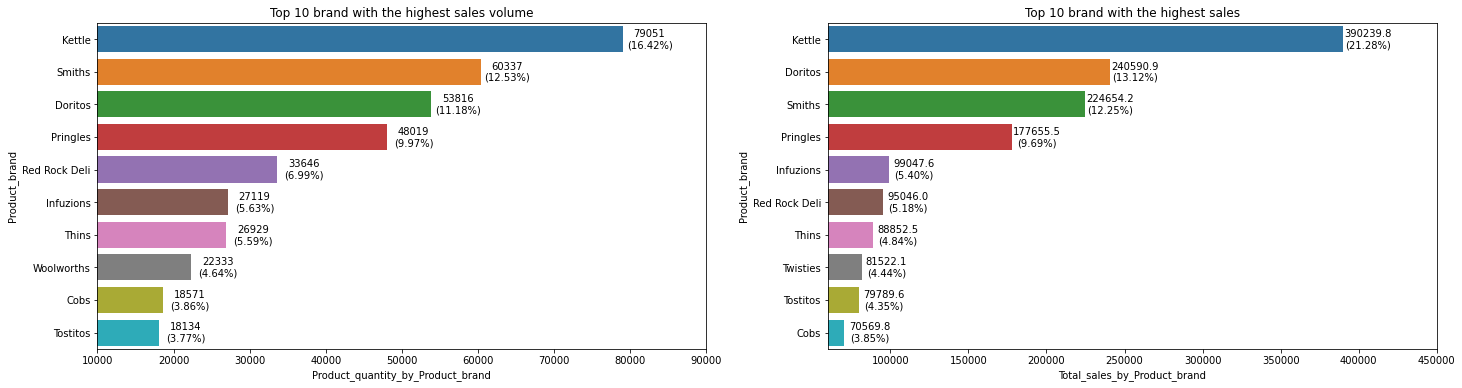

In [ ]:
 display_top_barchart(feature_name='Product_brand', top=10, sales_volume_range=(10000, 90000), sales_range=(60000,450000), title='brand', if_horizontal=True, figsize=(24,6),
                     gap_between_value_bar_volume=3500, gap_between_value_percentage_volume=0.35, gap_between_value_bar_sales=16000, gap_between_value_percentage_sales=0.35)

<font size=3> **Finding 1.6**
- <font size=3> **Customer 230078 and 162039 bought the most chips, up to 36 packs of chips each.**
- <font size=3> **Customer 230078 spent most money, up to 138.6 dollors, buying chips.**

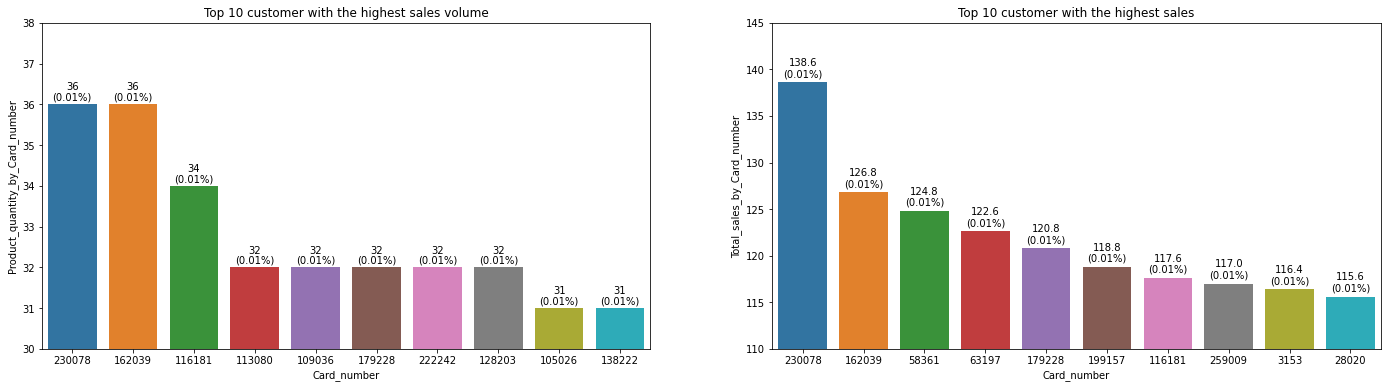

In [ ]:
 display_top_barchart(feature_name='Card_number', top=10, sales_volume_range=(30, 38), sales_range=(110,145), title='customer', if_horizontal=False, figsize=(24,6),
                     gap_between_value_bar_volume=0.1, gap_between_value_percentage_volume=0.25, gap_between_value_bar_sales=0.6, gap_between_value_percentage_sales=1.2)

<font size=3> **Finding 1.7**
- <font size=3> **Smiths sold most flavoured chips, up to 18 kinds of chips.**
- <font size=3> **French Fries and Burger Rings only had one flavour each.**

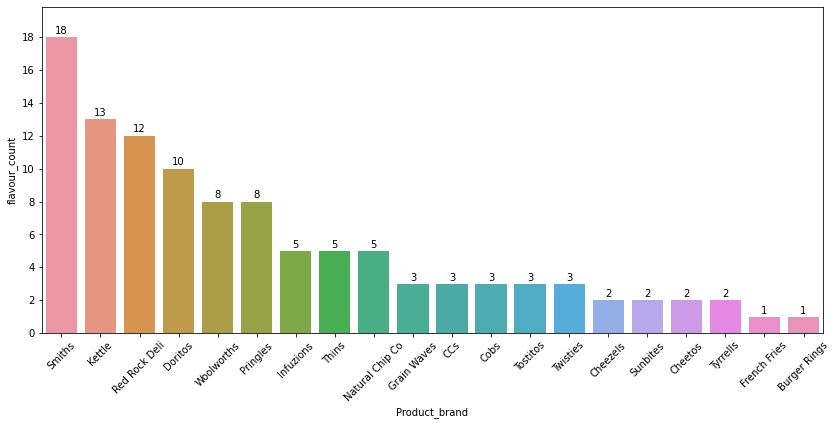

In [ ]:
#
fig = plt.figure(figsize=(14, 6))
brand_flavour = transaction[['Product_brand','Product_flavour']].drop_duplicates().groupby(['Product_brand']).size().reset_index(name='flavour_count')
ax = sns.barplot(data=brand_flavour.sort_values(by=['flavour_count'], ascending=False), x='Product_brand', y='flavour_count')
add_value_to_barchart(ax=ax, gap_between_value_bar=0.2, if_value_int=True)
plt.xticks(rotation = 45)
plt.yticks(range(0,19,2))
plt.show()

<font size=3> **Finding 1.8**
- <font size=3> **Most customers bought 2 packs of chips per transaction.**
- <font size=3> **Customers never bought more than 6 packs of chips per transaction.**

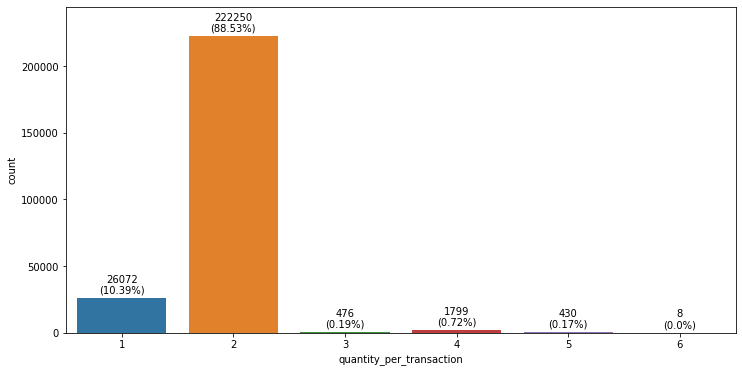

In [ ]:
#
fig = plt.figure(figsize=(12, 6))
quantity_per_transaction = transaction.groupby(['Transaction_id'])['Product_quantity'].sum().reset_index(name='quantity_per_transaction')
ax = sns.barplot(data = quantity_per_transaction[['quantity_per_transaction']].value_counts().reset_index(name='count').sort_values(by=['quantity_per_transaction']),
            x='quantity_per_transaction', y='count')
add_value_to_barchart(ax=ax, gap_between_value_bar=4000, if_value_int=True, if_percentage=True, gap_between_value_percentage=8000)

<font size=3> **Finding 1.9**
- <font size=3> **Almost all customers only bought one type of chips per transaction.**

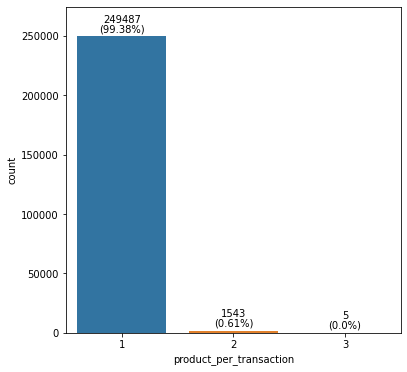

In [ ]:
#
fig = plt.figure(figsize=(6, 6))
product_per_transaction = transaction.groupby(['Transaction_id']).size().reset_index(name='product_per_transaction')
ax = sns.barplot(data = product_per_transaction[['product_per_transaction']].value_counts().reset_index(name='count'), x='product_per_transaction', y='count')
add_value_to_barchart(ax=ax, gap_between_value_bar=4000, if_value_int=True, if_percentage=True, gap_between_value_percentage=8000)

<font size=3> **Finding 1.10**
- <font size=3> **Around 27.22% of customers bought chips only once.**
- <font size=3> **As the purchase frequency increased, the proportion of customers decreased.**

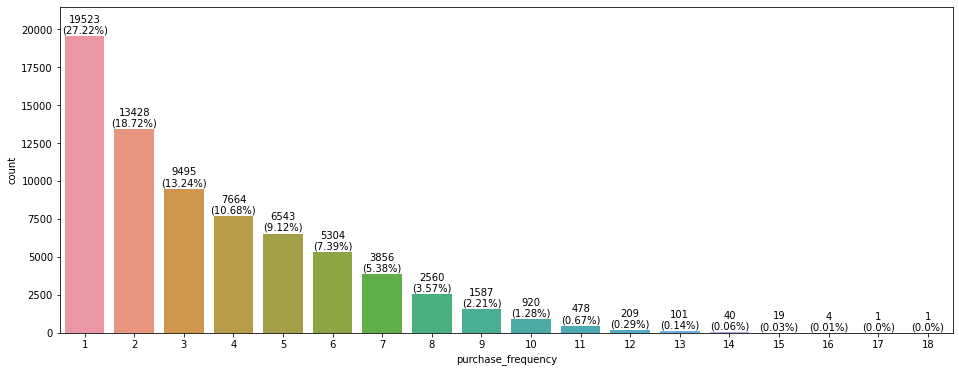

In [ ]:
#
card_transaction = transaction.groupby(['Card_number','Transaction_id']).size().reset_index(name='Frequency')
purchase_frequency = card_transaction.groupby(['Card_number']).size().reset_index(name='purchase_frequency')[['purchase_frequency']].value_counts().reset_index(name='count').sort_values(by=['purchase_frequency'])
purchase_frequency
#
fig = plt.figure(figsize=(16,6))
ax = sns.barplot(data=purchase_frequency, x='purchase_frequency', y='count')
add_value_to_barchart(ax=ax, gap_between_value_bar=200, if_value_int=True, if_percentage=True, gap_between_value_percentage=700)

<font size=4> Let's get some insights from the purchase behaviour dataset.
    
<font size=3> As the names of each customer segment are a little long, it is better to plot horizontal figures.

<font size=3> **Finding 2.1**
- <font size=3> **The numbers of RETIREES, OLDER SINGLES/COUPLES and YOUNG SINGLES/COUPLES customers were greated than other customers, accounting for around 20% of all customers each.**
- <font size=3> **Only 3.51% of the customers were NEW FAMILIES customers.**

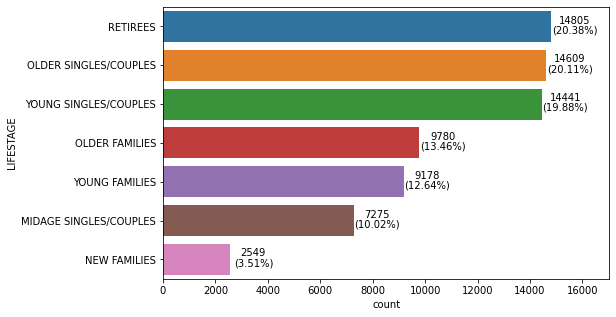

In [ ]:
#
lifestage = behaviour.groupby(['LIFESTAGE']).size().reset_index(name='count')
#
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(data=lifestage, x='count', y='LIFESTAGE', order=lifestage.sort_values(by=['count'], ascending=False)['LIFESTAGE'])
add_value_to_barchart(ax=ax, if_vertical=False, gap_between_value_bar=900, if_value_int=True, if_percentage=True, gap_between_value_percentage=0.25)


<font size=3> **Finding 2.2**
- <font size=3> **Mainstream had the most customers and Premium had the fewest customers.**

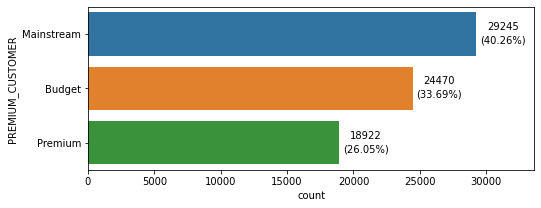

In [ ]:
#
premium = behaviour.groupby(['PREMIUM_CUSTOMER']).size().reset_index(name='count')
#
fig = plt.figure(figsize=(8,3))
ax = sns.barplot(data=premium, x='count', y='PREMIUM_CUSTOMER', order=premium.sort_values(by=['count'], ascending=False)['PREMIUM_CUSTOMER'])
add_value_to_barchart(ax=ax, if_vertical=False, gap_between_value_bar=2000, if_value_int=True, if_percentage=True, gap_between_value_percentage=0.25)

In [ ]:
# plot stacked bar chart with percent
def plot_horizontal_stacked_bar_with_percent(df, target_variable, group_variable, if_sort=False, sort_by=None, figsize=(9,6)):
    plot_data = df.groupby([target_variable, group_variable]).size().reset_index(name='count')
    plot_data = plot_data.pivot(index=target_variable, columns=group_variable, values='count').fillna(0)
    plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
    if if_sort:
        # arrange column's order
        cols = plot_data.columns.values
        cols = np.delete(cols, np.argwhere(cols==sort_by))
        plot_data = plot_data[np.append(np.array([sort_by]), cols)]
        plot_data = plot_data.sort_values(by=[sort_by])
    ax = plot_data.plot(kind='barh', rot=False, stacked=True, figsize=figsize)
    plt.legend(ncol=len(df[group_variable].unique()), bbox_to_anchor=(0.01, 1))
    num_unique = len(df[target_variable].unique())
    bar_heights=[0] * num_unique
    bar_idx = 0
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width()*100)
        bar_heights[bar_idx%num_unique] += p.get_width()/2
        if percentage!='0.0%':
            x = bar_heights[bar_idx%num_unique]
            y = p.get_y() + p.get_height()*0.4
            ax.annotate(text=percentage, xy=(x, y), ha='center')
        bar_heights[bar_idx%num_unique] += p.get_width()/2
        bar_idx += 1
    plt.show()

<font size=3> **Finding 2.3**
- <font size=3> **OLDER SINGLES/COUPLES customers accounted for the highest proportion in Budget customers and Premium customers.**
- <font size=3> **YOUNG SINGLES/COUPLES customers accounted for the highest proportion in Mainstream customers.**

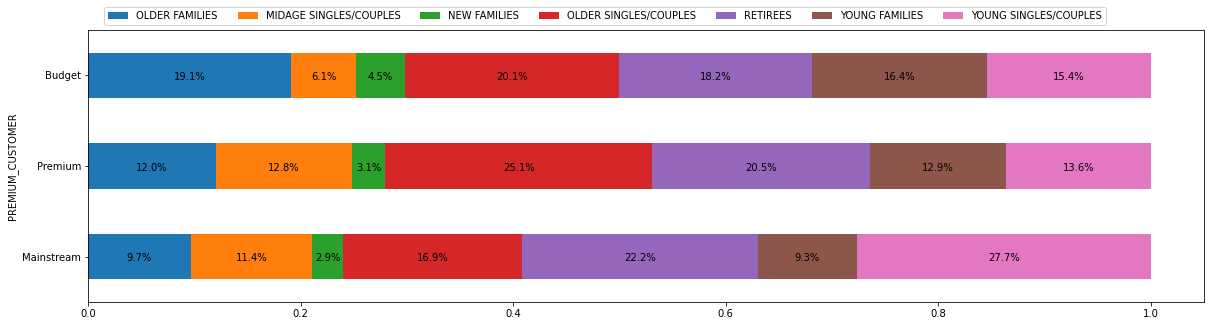

In [ ]:
plot_horizontal_stacked_bar_with_percent(df=behaviour, target_variable='PREMIUM_CUSTOMER', group_variable='LIFESTAGE', if_sort=True, sort_by='OLDER FAMILIES', figsize=(20,5))

<font size=3> **Finding 2.4**
- <font size=3> **OLDER FAMILIES customers had the highest proportion of Budget customers, up to 47.8%.**
- <font size=3> **MIDAGE SINGLES/COUPLES customers had the lowest proportion of Budget customers, only 20.7%.**

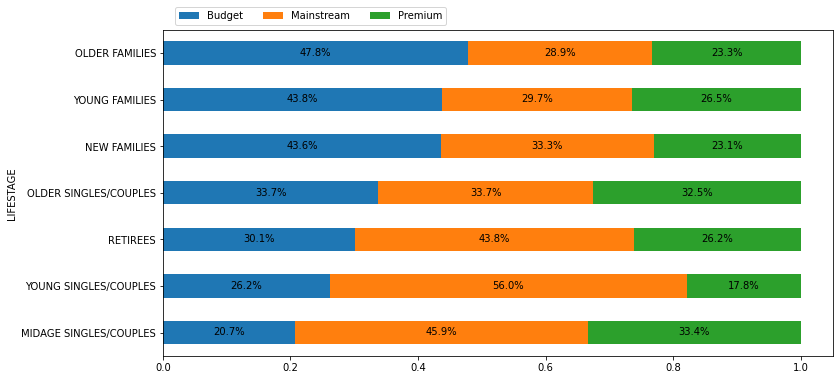

In [ ]:
plot_horizontal_stacked_bar_with_percent(df=behaviour, target_variable='LIFESTAGE', group_variable='PREMIUM_CUSTOMER', if_sort=True, sort_by='Budget', figsize=(12,6))

- <font size=3> **YOUNG SINGLES/COUPLES customers had the highest proportion of Mainstream customers, up to 56.0%.**
- <font size=3> **OLDER FAMILIES customers had the lowest proportion of Mainstream customers, only 28.9%.**

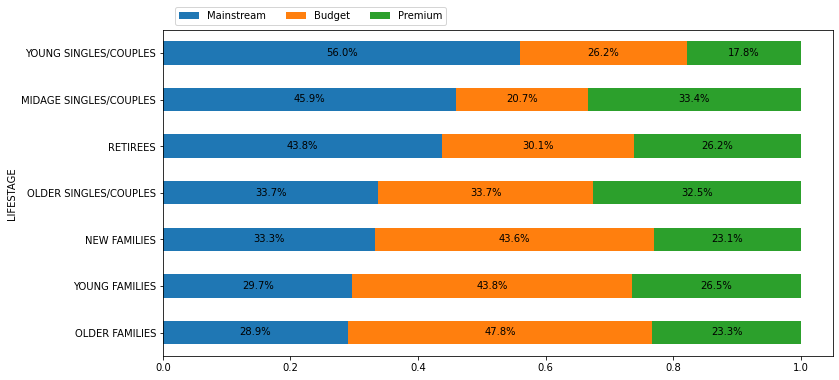

In [ ]:
plot_horizontal_stacked_bar_with_percent(df=behaviour, target_variable='LIFESTAGE', group_variable='PREMIUM_CUSTOMER', if_sort=True, sort_by='Mainstream', figsize=(12,6))

- <font size=3> **MIDAGE SINGLES/COUPLES customers had the highest proportion of Premium customers, up to 33.4%.**
- <font size=3> **YOUNG SINGLES/COUPLES customers had the lowest proportion of Premium customers, only 17.8%.**

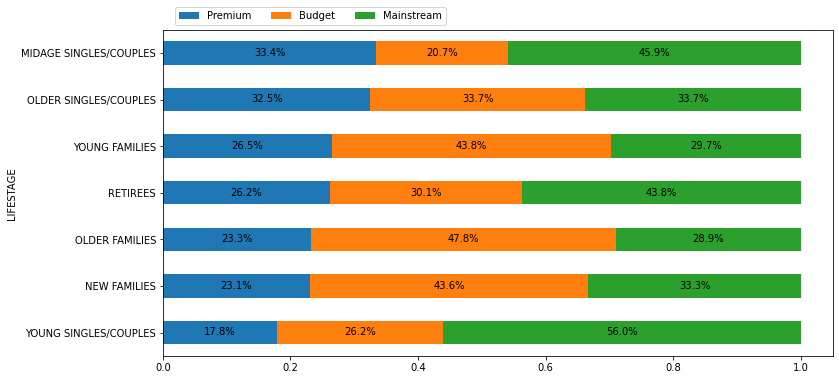

In [ ]:
plot_horizontal_stacked_bar_with_percent(df=behaviour, target_variable='LIFESTAGE', group_variable='PREMIUM_CUSTOMER', if_sort=True, sort_by='Premium', figsize=(12,6))

<font size=3> Create customer segment based on LIFESTAGE and PREMIUM_CUSTOMER.

In [ ]:
behaviour['customer_segment'] = behaviour['LIFESTAGE'] + '-' + behaviour['PREMIUM_CUSTOMER']

<font size=3> **Finding 2.5**
- <font size=3> **YOUNG SINGLES/COUPLES-Mainstream customers accounts for the highest proportion of customers, up to 11.13%.**
- <font size=3> **NEW FAMILIES-Premium customers accounts for the lowest proportion of customers, only 0.81%.**

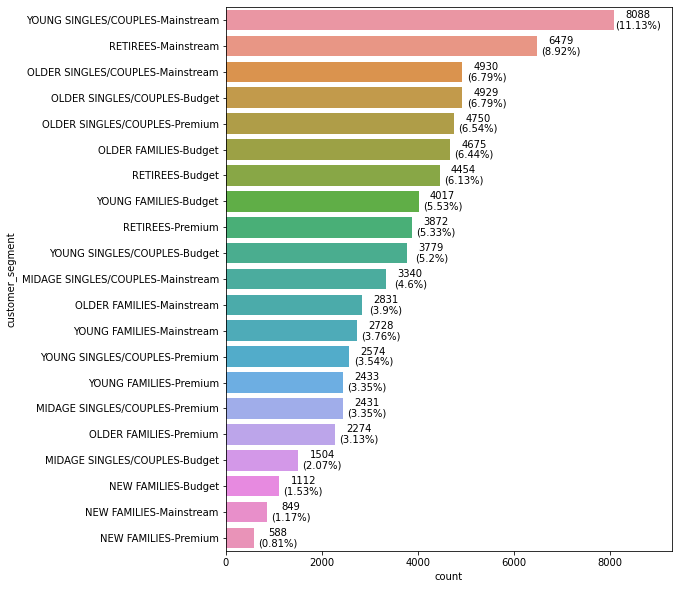

In [ ]:
#
customer_segment = behaviour.groupby(['customer_segment']).size().reset_index(name='count')
#
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(data=customer_segment, x='count', y='customer_segment', order=customer_segment.sort_values(by=['count'], ascending=False)['customer_segment'])
add_value_to_barchart(ax=ax, if_vertical=False, gap_between_value_bar=500, if_value_int=True, if_percentage=True, gap_between_value_percentage=0.4)

<font size=4> Merge behaviour dataset into transaction dataset to get more insights.
    
<font size=3> The new dataset does not have missing values, which means all customers in the transcation dataset are included in the behaviour dataset.

In [ ]:
# combine two datasets
full = transaction.merge(behaviour, on=['Card_number'], how='left')
full.isna().sum()

DATE                    0
Store_number            0
Card_number             0
Transaction_id          0
Product_number          0
Product_name            0
Product_quantity        0
Total_sales             0
Date                    0
Product_price           0
Month                   0
Dayofweek               0
Product_weight          0
Total_product_weight    0
Product_brand           0
Product_flavour         0
Product_Name            0
LIFESTAGE               0
PREMIUM_CUSTOMER        0
customer_segment        0
dtype: int64

<font size=3> **Finding 2.6**
- <font size=3> **OLDER SINGLES/COUPLES customers bought the most chips and brought the highest sales revenue.**
- <font size=3> **NEW FAMILIES customers bought the fewest chips and brought the lowest sales revenue.**
- <font size=3> **Each OLDER FAMILIES customers bought the most chips and brought the highest sales revenue.**
- <font size=3> **Each YOUNG SINGLES/COUPLES customers bought the fewest chips and brought the lowest sales revenue.**

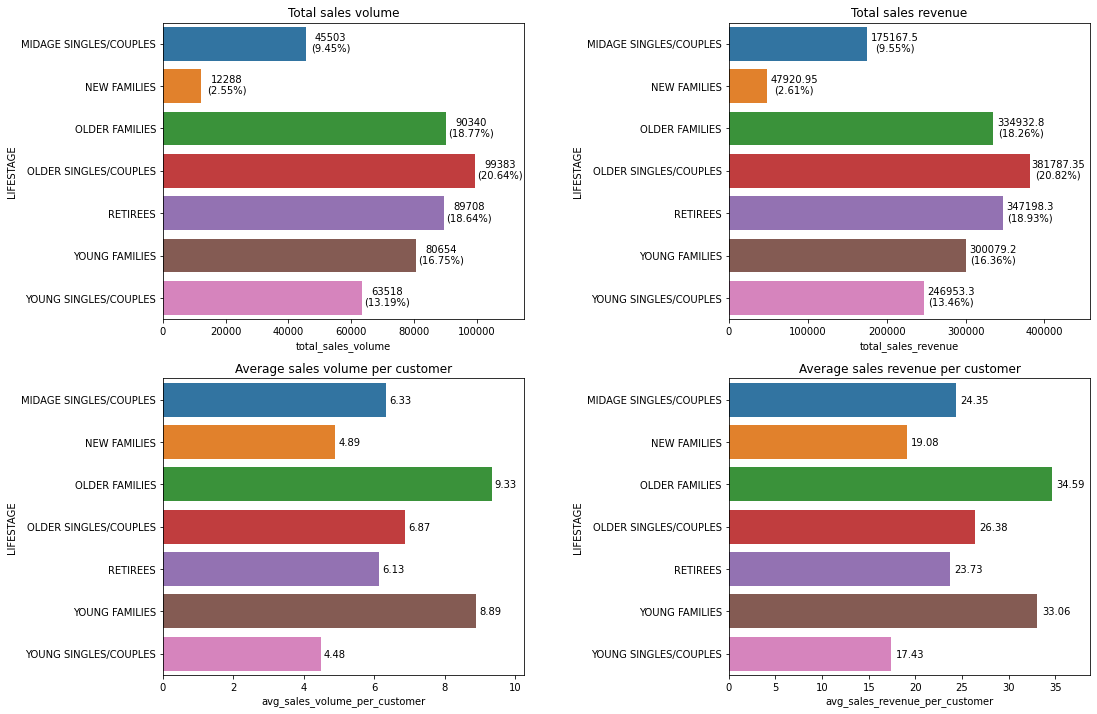

In [ ]:
#
lifestage_sales_volume = full.groupby(['LIFESTAGE']).sum()['Product_quantity'].reset_index(name='total_sales_volume')
lifestage_sales_revenue = full.groupby(['LIFESTAGE']).sum()['Total_sales'].reset_index(name='total_sales_revenue')
lifestage_sales_volume_avg = full.groupby(['LIFESTAGE','Card_number']).sum()['Product_quantity'].reset_index(name='sales_volume')
lifestage_sales_volume_avg = lifestage_sales_volume_avg.groupby(['LIFESTAGE']).mean()['sales_volume'].reset_index(name='avg_sales_volume_per_customer')
lifestage_sales_revenue_avg = full.groupby(['LIFESTAGE','Card_number']).sum()['Total_sales'].reset_index(name='sales_revenue')
lifestage_sales_revenue_avg = lifestage_sales_revenue_avg.groupby(['LIFESTAGE']).mean()['sales_revenue'].reset_index(name='avg_sales_revenue_per_customer')
# create a figure
fig = plt.figure(figsize=(20, 12))
# total sales volume
ax1 = plt.subplot2grid((2, 12), (0, 1), colspan=4)
sns.barplot(ax=ax1, data=lifestage_sales_volume, y='LIFESTAGE', x='total_sales_volume')
add_value_to_barchart(ax=ax1, if_vertical=False, gap_between_value_bar=8000, if_value_int=True, if_percentage=True, gap_between_value_percentage=0.25, xmargin=0.16)
plt.title("Total sales volume")
# total sales revenue
ax2 = plt.subplot2grid((2, 12), (0, 7), colspan=4)
sns.barplot(ax=ax2, data=lifestage_sales_revenue, y='LIFESTAGE', x='total_sales_revenue')
add_value_to_barchart(ax=ax2, if_vertical=False, gap_between_value_bar=35000, if_percentage=True, gap_between_value_percentage=0.25, xmargin=0.2)
plt.title("Total sales revenue")
# average sales volume per customer
ax3 = plt.subplot2grid((2, 12), (1, 1), colspan=4)
sns.barplot(ax=ax3, data=lifestage_sales_volume_avg, y='LIFESTAGE', x='avg_sales_volume_per_customer')
add_value_to_barchart(ax=ax3, if_vertical=False, gap_between_value_bar=0.4, xmargin=0.1)
plt.title("Average sales volume per customer")
# average sales revenue per customer
ax4 = plt.subplot2grid((2, 12), (1, 7), colspan=4)
sns.barplot(ax=ax4, data=lifestage_sales_revenue_avg, y='LIFESTAGE', x='avg_sales_revenue_per_customer')
add_value_to_barchart(ax=ax4, if_vertical=False, gap_between_value_bar=2, xmargin=0.12)
plt.title("Average sales revenue per customer")
plt.show()

<font size=3> **Finding 2.7**
- <font size=3> **NEW FAMILIES customers tended to buy more expensive chips.**
- <font size=3> **OLDER FAMILIES customers bought tended to buy cheaper chips.**

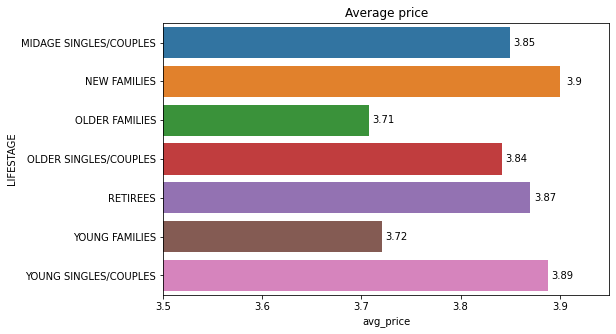

In [ ]:
#
lifestage_sales_volume['avg_price'] = lifestage_sales_revenue['total_sales_revenue']/lifestage_sales_volume['total_sales_volume']
#
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(data=lifestage_sales_volume, y='LIFESTAGE', x='avg_price')
add_value_to_barchart(ax=ax, if_vertical=False, gap_between_value_bar=0.015, xmargin=0.12)
plt.title("Average price")
plt.xlim(3.5,3.95)
plt.show()

<font size=3> **Finding 2.8**
- <font size=3> **OLDER FAMILIES-Budget customers bought the most chips and brought the highest sales revenue.**
- <font size=3> **NEW FAMILIES-Premium customers bought the fewest chips and brought the lowest sales revenue.**
- <font size=3 style="color:red"> **For the same LIFESTAGE group of customers, PREMIUM_CUSTOMER almost had no impact on the average sales volume and the average sales revenue per customer.**

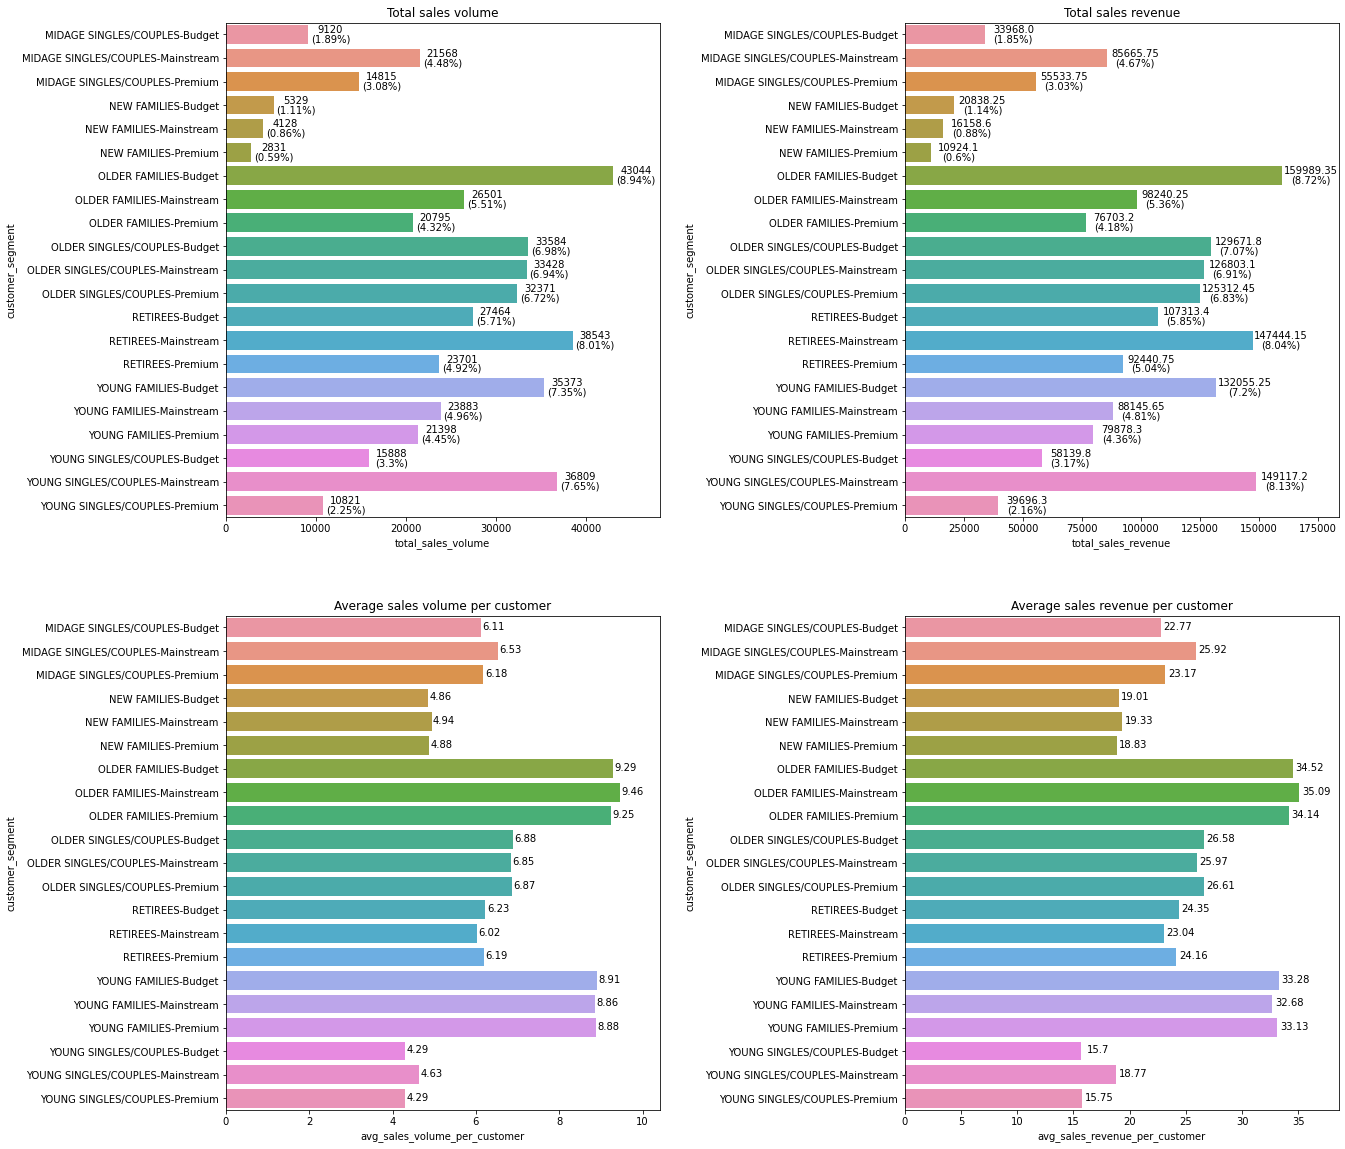

In [ ]:
#
segment_sales_volume = full.groupby(['customer_segment']).sum()['Product_quantity'].reset_index(name='total_sales_volume')
segment_sales_revenue = full.groupby(['customer_segment']).sum()['Total_sales'].reset_index(name='total_sales_revenue')
segment_sales_volume_avg = full.groupby(['customer_segment','Card_number']).sum()['Product_quantity'].reset_index(name='sales_volume')
segment_sales_volume_avg = segment_sales_volume_avg.groupby(['customer_segment']).mean()['sales_volume'].reset_index(name='avg_sales_volume_per_customer')
segment_sales_revenue_avg = full.groupby(['customer_segment','Card_number']).sum()['Total_sales'].reset_index(name='sales_revenue')
segment_sales_revenue_avg = segment_sales_revenue_avg.groupby(['customer_segment']).mean()['sales_revenue'].reset_index(name='avg_sales_revenue_per_customer')
# create a figure
fig = plt.figure(figsize=(24, 20))
# total sales volume
ax1 = plt.subplot2grid((2, 12), (0, 1), colspan=4)
sns.barplot(ax=ax1, data=segment_sales_volume, y='customer_segment', x='total_sales_volume')
add_value_to_barchart(ax=ax1, if_vertical=False, gap_between_value_bar=2500, if_value_int=True, if_percentage=True, gap_between_value_percentage=0.4, xmargin=0.12)
plt.title("Total sales volume")
# total sales revenue
ax2 = plt.subplot2grid((2, 12), (0, 7), colspan=4)
sns.barplot(ax=ax2, data=segment_sales_revenue, y='customer_segment', x='total_sales_revenue')
add_value_to_barchart(ax=ax2, if_vertical=False, gap_between_value_bar=12000, if_percentage=True, gap_between_value_percentage=0.4, xmargin=0.15)
plt.title("Total sales revenue")
# average sales volume per customer
ax3 = plt.subplot2grid((2, 12), (1, 1), colspan=4)
sns.barplot(ax=ax3, data=segment_sales_volume_avg, y='customer_segment', x='avg_sales_volume_per_customer')
add_value_to_barchart(ax=ax3, if_vertical=False, gap_between_value_bar=0.3, xmargin=0.1)
plt.title("Average sales volume per customer")
# average sales revenue per customer
ax4 = plt.subplot2grid((2, 12), (1, 7), colspan=4)
sns.barplot(ax=ax4, data=segment_sales_revenue_avg, y='customer_segment', x='avg_sales_revenue_per_customer')
add_value_to_barchart(ax=ax4, if_vertical=False, gap_between_value_bar=1.5, xmargin=0.1)
plt.title("Average sales revenue per customer")
plt.show()

<font size=3> **Finding 2.9**
- <font size=3> **YOUNG SINGLES/COUPLES-Mainstream customers tended to buy more expensive chips.**
- <font size=3> **YOUNG SINGLES/COUPLES-Budget customers bought tended to buy cheaper chips.**

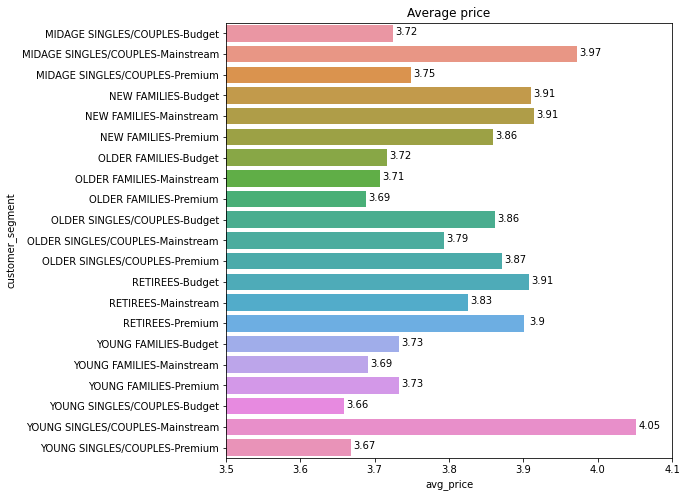

In [ ]:
#
segment_sales_volume['avg_price'] = segment_sales_revenue['total_sales_revenue']/segment_sales_volume['total_sales_volume']
#
fig = plt.figure(figsize=(8,8))
ax = sns.barplot(data=segment_sales_volume, y='customer_segment', x='avg_price')
add_value_to_barchart(ax=ax, if_vertical=False, gap_between_value_bar=0.018, xmargin=0.12)
plt.title("Average price")
plt.xlim(3.5,4.1)
plt.show()

<font size=3> **Finding 2.10**
- <font size=3> **Kettle chips were the most popular chips for any LIFESTAGE group of cutomers.**

In [ ]:
#
lifestage_brand = full.groupby(['LIFESTAGE','Product_brand']).sum()['Product_quantity'].reset_index(name='sales_volume')
lifestage_brand = lifestage_brand.sort_values(by=['LIFESTAGE','sales_volume'], ascending=False)
lifestage_brand.groupby(['LIFESTAGE']).nth(0)

,Product_brand,sales_volume
LIFESTAGE,,
MIDAGE SINGLES/COUPLES,Kettle,7755
NEW FAMILIES,Kettle,2191
OLDER FAMILIES,Kettle,13367
OLDER SINGLES/COUPLES,Kettle,17024
RETIREES,Kettle,15568
YOUNG FAMILIES,Kettle,12153
YOUNG SINGLES/COUPLES,Kettle,10993


- <font size=3> **Kettle chips were also the most popular chips for any customer_segment group of cutomers.**

In [ ]:
#
segment_brand = full.groupby(['customer_segment','Product_brand']).sum()['Product_quantity'].reset_index(name='sales_volume')
segment_brand = segment_brand.sort_values(by=['customer_segment','sales_volume'], ascending=False)
segment_brand.groupby(['customer_segment']).nth(0)

,Product_brand,sales_volume
customer_segment,,
MIDAGE SINGLES/COUPLES-Budget,Kettle,1365
MIDAGE SINGLES/COUPLES-Mainstream,Kettle,4085
MIDAGE SINGLES/COUPLES-Premium,Kettle,2305
NEW FAMILIES-Budget,Kettle,954
NEW FAMILIES-Mainstream,Kettle,781
NEW FAMILIES-Premium,Kettle,456
OLDER FAMILIES-Budget,Kettle,6492
OLDER FAMILIES-Mainstream,Kettle,3938
OLDER FAMILIES-Premium,Kettle,2937


<font size=3> **Finding 2.11**
- <font size=3> **RETIREES and YOUNG SINGLES/COUPLES customers had the same favourite chips (Kettle Mozzarella Basil Pesto 175g).**
- <font size=3> **Each of the rest groups of cutomers had their exclusive favourite chips.**

In [ ]:
# favourite chips
lifestage_brand_name = full.groupby(['LIFESTAGE','Product_Name']).sum()['Product_quantity'].reset_index(name='sales_volume')
lifestage_brand_name = lifestage_brand_name.sort_values(by=['LIFESTAGE','sales_volume'], ascending=False)
lifestage_brand_name.groupby(['LIFESTAGE']).nth(0)

,Product_Name,sales_volume
LIFESTAGE,,
MIDAGE SINGLES/COUPLES,Infuzions Crn Crnchers Tangy Gcamole 110g,656
NEW FAMILIES,Cobs Popd Swt Chlli Sr Cream Chips 110g,197
OLDER FAMILIES,Smiths Crinkle Chips Salt Vinegar 330g,1149
OLDER SINGLES/COUPLES,Kettle Swt Pot Sea Salt 135g,1417
RETIREES,Kettle Mozzarella Basil Pesto 175g,1284
YOUNG FAMILIES,Kettle Original 175g,1040
YOUNG SINGLES/COUPLES,Kettle Mozzarella Basil Pesto 175g,956


- <font size=3> **NEW FAMILIES-Premium and RETIREES-Mainstream customers had the same favourite chips (Grain Waves Sweet Chilli 210g).**
- <font size=3> **OLDER FAMILIES-Budget and YOUNG SINGLES/COUPLES-Mainstream customers had the same favourite chips (Kettle Mozzarella Basil Pesto 175g).**
- <font size=3> **OLDER FAMILIES-Mainstream and YOUNG SINGLES/COUPLES-Premium customers had the same favourite chips (Cobs Popd Sour Crm Chives Chips 110g).**
- <font size=3> **Each of the rest customer_segment groups of cutomers had their exclusive favourite chips.**

In [ ]:
# favourite chips
segment_brand_name = full.groupby(['customer_segment','Product_Name']).sum()['Product_quantity'].reset_index(name='sales_volume')
segment_brand_name = segment_brand_name.sort_values(by=['customer_segment','sales_volume'], ascending=False)
segment_brand_name.groupby(['customer_segment']).nth(0)

,Product_Name,sales_volume
customer_segment,,
MIDAGE SINGLES/COUPLES-Budget,Infuzions Crn Crnchers Tangy Gcamole 110g,147
MIDAGE SINGLES/COUPLES-Mainstream,Smiths Crinkle Chips Salt Vinegar 330g,369
MIDAGE SINGLES/COUPLES-Premium,Pringles Sweet Spcy BBQ 134g,221
NEW FAMILIES-Budget,Kettle Honey Soy Chicken 175g,95
NEW FAMILIES-Mainstream,Doritos Mexicana 170g,74
NEW FAMILIES-Premium,Grain Waves Sweet Chilli 210g,59
OLDER FAMILIES-Budget,Kettle Mozzarella Basil Pesto 175g,561
OLDER FAMILIES-Mainstream,Cobs Popd Sour Crm Chives Chips 110g,352
OLDER FAMILIES-Premium,Pringles Chicken Salt Crips 134g,290


<font size=4> Each LIFESTAGE group of customers had their own purchasing behaviours.  

<font size=3>    **Finding 2.12**
- <font size=3> **MIDAGE SINGLES/COUPLES bought the most chips in April and the fewest in August.**
- <font size=3> **NEW FAMILIES bought the most in February and the fewest in July.**
- <font size=3> **OLDER FAMILIES bought the most in December and the fewest in May.**
- <font size=3> **OLDER SINGLES/COUPLES bought the most in December and the fewest in May.**
- <font size=3> **RETIREES bought the most in December and the fewest in August.**
- <font size=3> **YOUNG FAMILIES bought the most in December and the fewest in August.**
- <font size=3> **YOUNG SINGLES/COUPLES bought the most in December and the fewest in May.**

<font size=3> **Overall, customers bought the more chips in December and fewer in May and August. This result is identical with Finding 1-1.**

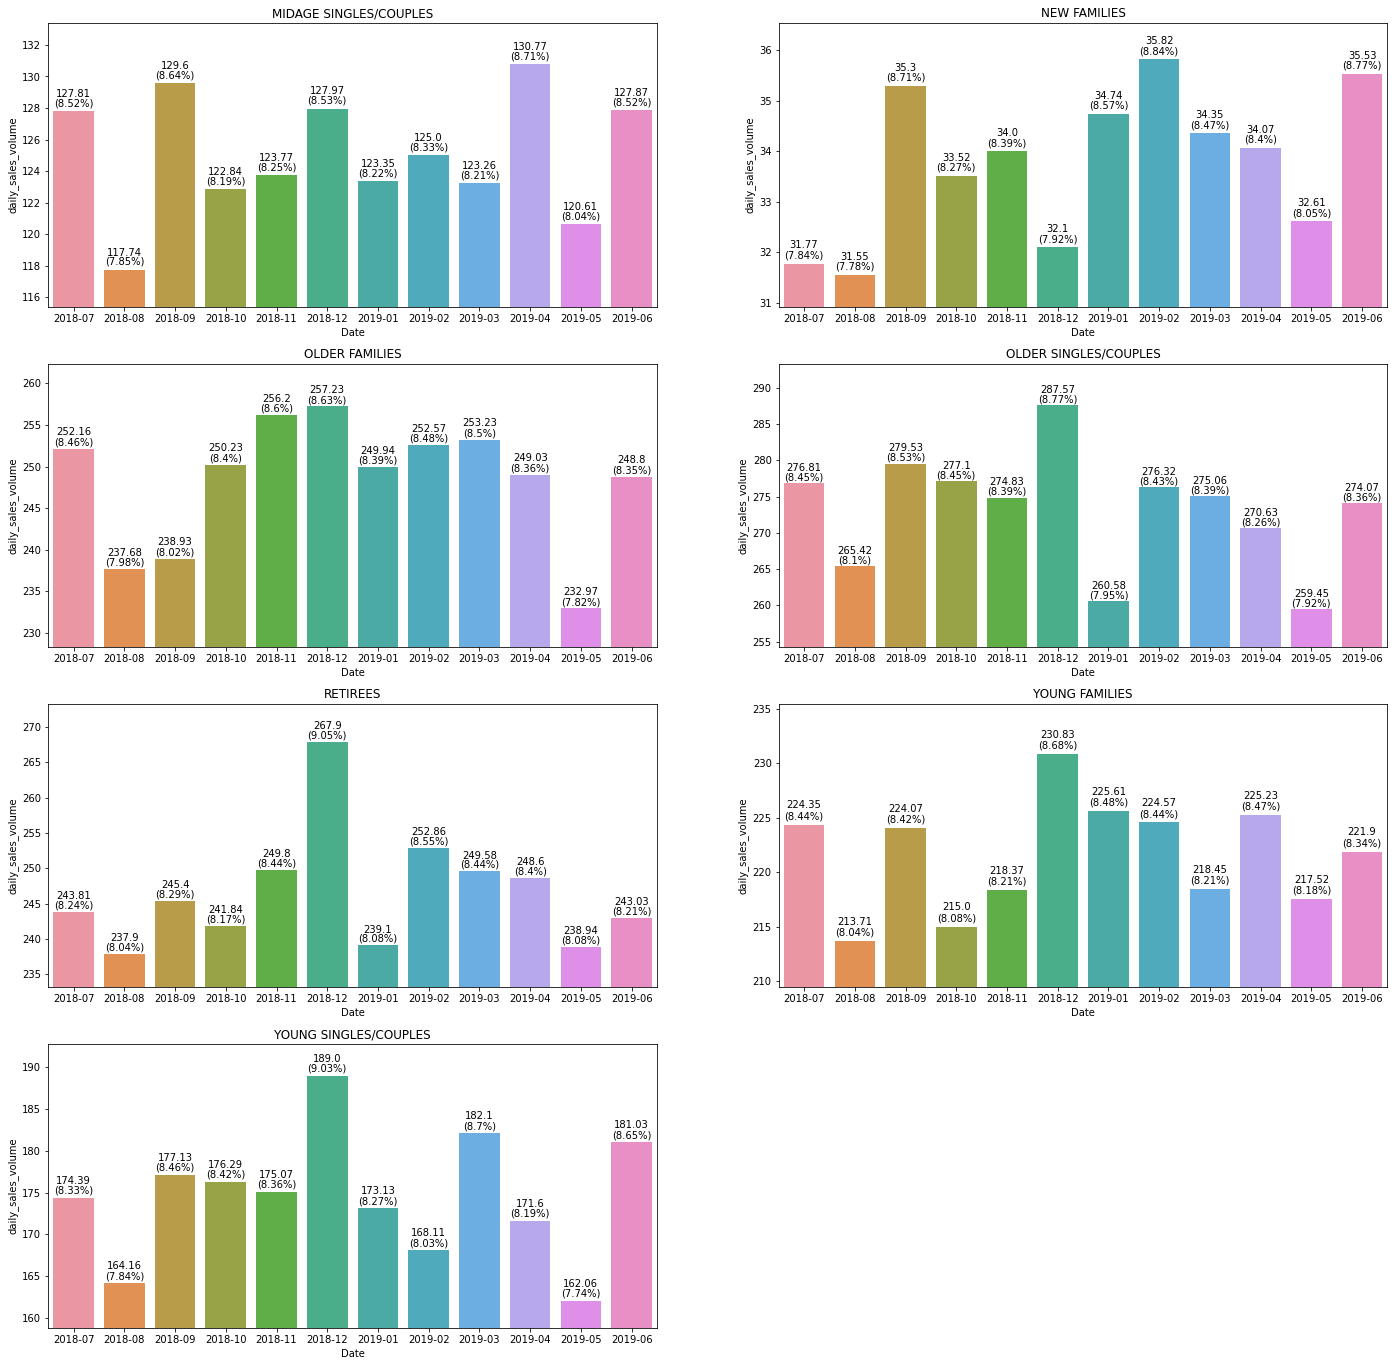

In [ ]:
#
lifestage_month = full.groupby(['LIFESTAGE','DATE','Date']).sum()['Product_quantity'].reset_index(name='daily_sales_volume')
lifestage_month = lifestage_month.groupby(['LIFESTAGE','Date']).mean().reset_index()
lifestage_unique = lifestage_month['LIFESTAGE'].unique()
#
fig = plt.figure(figsize=(24, 24))
gaps = [[0.3,0.6],[0.1,0.2],[0.4,1.2],[0.4,1.3],[0.5,1.3],[0.5,1],[0.5,1.2]]
plot_idx = 1
for i in range(len(lifestage_unique)):
    fig.add_subplot(4, 2, plot_idx)
    plot_data = lifestage_month[lifestage_month['LIFESTAGE']==lifestage_unique[i]]
    ax = sns.barplot(data=plot_data, x='Date',y='daily_sales_volume')
    plt.ylim(plot_data['daily_sales_volume'].min()*0.98, plot_data['daily_sales_volume'].max()*1.02)
    plt.title(lifestage_unique[i])
    add_value_to_barchart(ax=ax, gap_between_value_bar=gaps[i][0], if_percentage=True, gap_between_value_percentage=gaps[i][1])
    plot_idx+=1

<font size=3> **Finding 2.13**
- <font size=3> **MIDAGE SINGLES/COUPLES bought the most chips on Tuesdays and the fewest on Fridays.**
- <font size=3> **NEW FAMILIES bought the most chips on Fridays and the fewest on Mondays.**
- <font size=3> **OLDER FAMILIES bought the most chips on Thursday and the fewest on Wednesdays.**
- <font size=3> **OLDER SINGLES/COUPLES bought the most chips on Thursday and the fewest on Wednesdays.**
- <font size=3> **RETIREES bought the most chips on Thursday and the fewest on Fridays.**
- <font size=3> **YOUNG FAMILIES bought the most chips on Thursday and the fewest on Sundays.**
- <font size=3> **YOUNG SINGLES/COUPLES bought the most chips on Mondays and the fewest on Wednesdays.**
    
<font size=3> **Overall, customers bought the more chips on Thursday and fewer on Wednesdays. This result is also identical with Finding 1-2.**

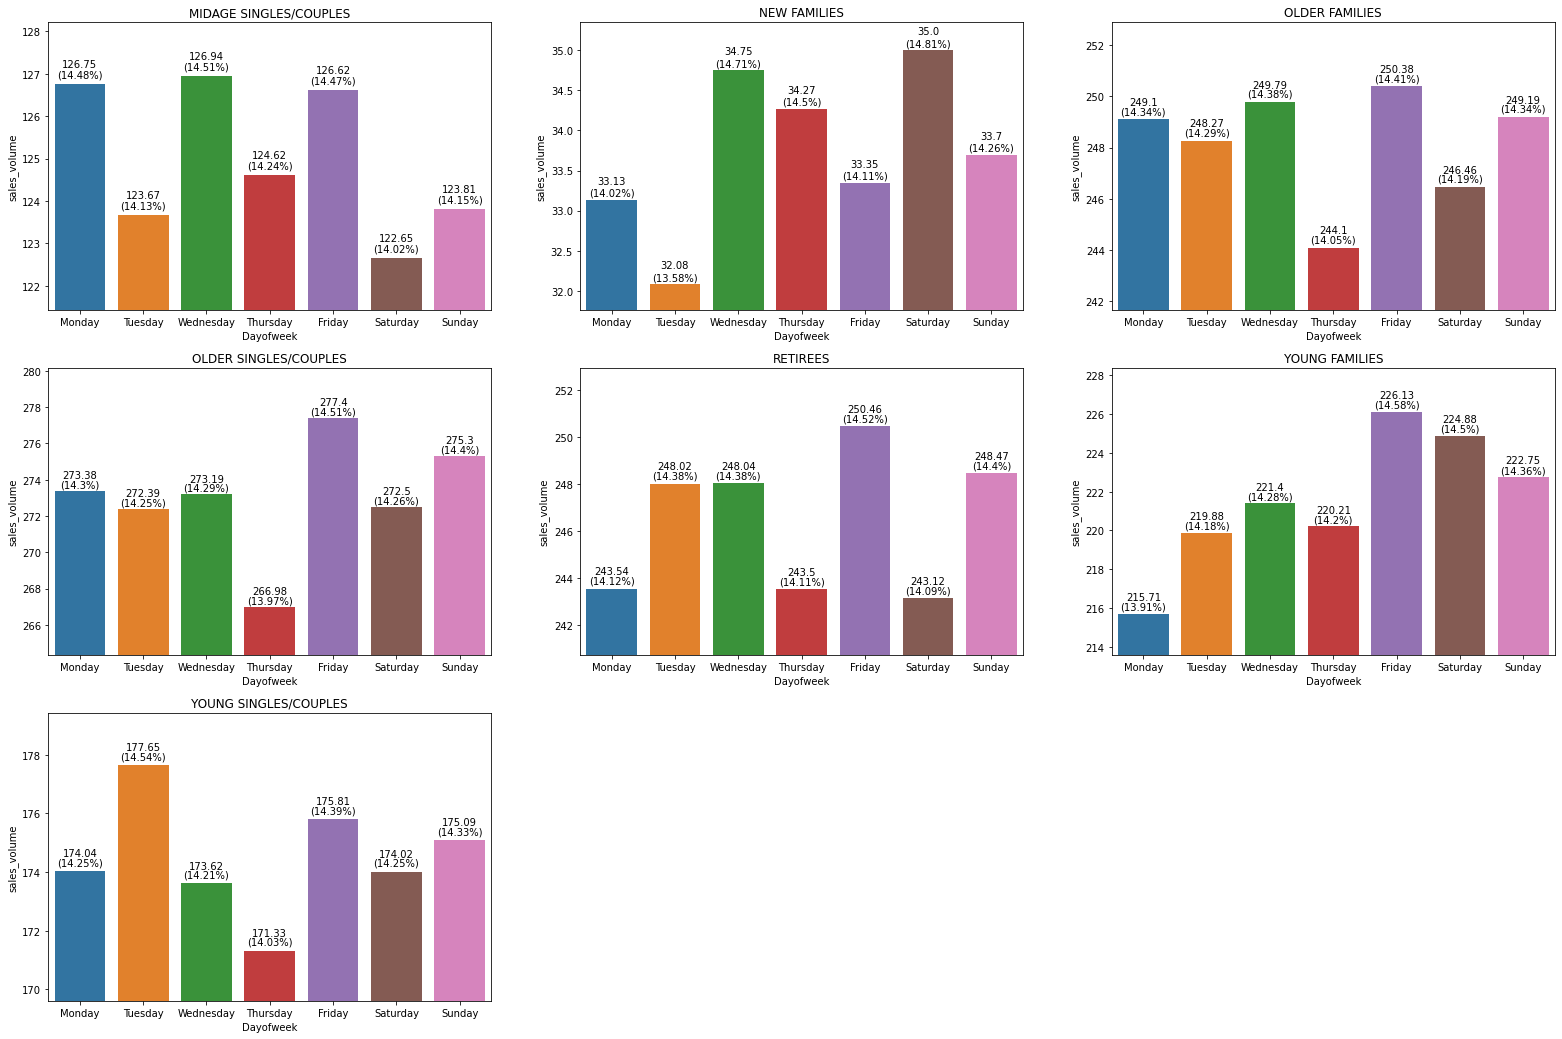

In [ ]:
#
lifestage_weekday = full.groupby(['LIFESTAGE','DATE','Dayofweek']).sum()['Product_quantity'].reset_index(name='sales_volume')
lifestage_weekday = lifestage_weekday.groupby(['LIFESTAGE','Dayofweek']).mean().reset_index()
lifestage_unique = lifestage_weekday['LIFESTAGE'].unique()
#
fig = plt.figure(figsize=(27, 18))
gaps = [[0.15,0.25],[0.05,0.15],[0.2,0.35],[0.2,0.5],[0.2,0.4],[0.2,0.5],[0.2,0.3]]
plot_idx = 1
for i in range(len(lifestage_unique)):
    fig.add_subplot(3, 3, plot_idx)
    plot_data = lifestage_weekday[lifestage_weekday['LIFESTAGE']==lifestage_unique[i]]
    ax = sns.barplot(data=plot_data, x='Dayofweek',y='sales_volume', order=display_order)
    plt.ylim(plot_data['sales_volume'].min()*0.99, plot_data['sales_volume'].max()*1.01)
    plt.title(lifestage_unique[i])
    add_value_to_barchart(ax=ax, gap_between_value_bar=gaps[i][0], if_percentage=True, gap_between_value_percentage=gaps[i][1])
    plot_idx+=1

<font size=3> **Finding 2.14**
- <font size=3> **Most stores had 200 to 400 customers each.**
- <font size=3> **The store 92 and store 76 only had one customer.**
- <font size=3> **The store 203 had the most customers, up to 395 customers.**

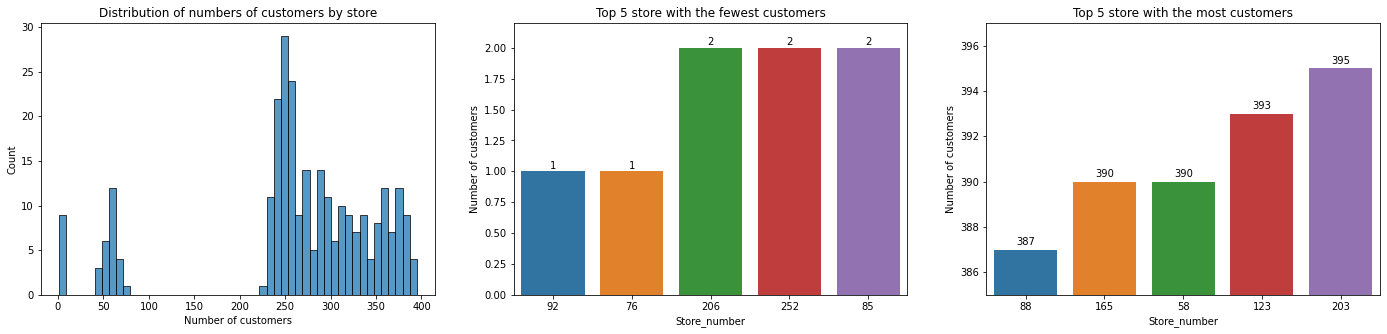

In [ ]:
#
store_card_lifestage = full[['Store_number','Card_number','LIFESTAGE']].drop_duplicates().reset_index(drop=True)
store_card = store_card_lifestage.groupby(['Store_number']).size().reset_index(name='Number of customers')
#
fig = plt.figure(figsize=(24, 5))
# distribution of customers by store
fig.add_subplot(1, 3, 1)
ax = sns.histplot(data=store_card, x='Number of customers', bins=50)
plt.title('Distribution of numbers of customers by store')
# fewest cutomers
fig.add_subplot(1, 3, 2)
ax = sns.barplot(data=store_card, x='Store_number', y='Number of customers', order=store_card.sort_values(by=['Number of customers'])['Store_number'][:5])
add_value_to_barchart(ax=ax, gap_between_value_bar=0.02, if_value_int=True)
plt.title('Top 5 store with the fewest customers')
# most customers
fig.add_subplot(1, 3, 3)
ax = sns.barplot(data=store_card, x='Store_number', y='Number of customers', order=store_card.sort_values(by=['Number of customers'])['Store_number'][-5:])
add_value_to_barchart(ax=ax, gap_between_value_bar=0.2, if_value_int=True)
plt.title('Top 5 store with the most customers')
plt.ylim(385,397)
plt.show()

- <font size=3> **The numbers of transactions cluster around 3 points: 50, 500, 1400.**
- <font size=3> **The store 92 and store 76 only had one transcation.**
- <font size=3> **The store 226 had the most transcations, up to 1905 transcations.**

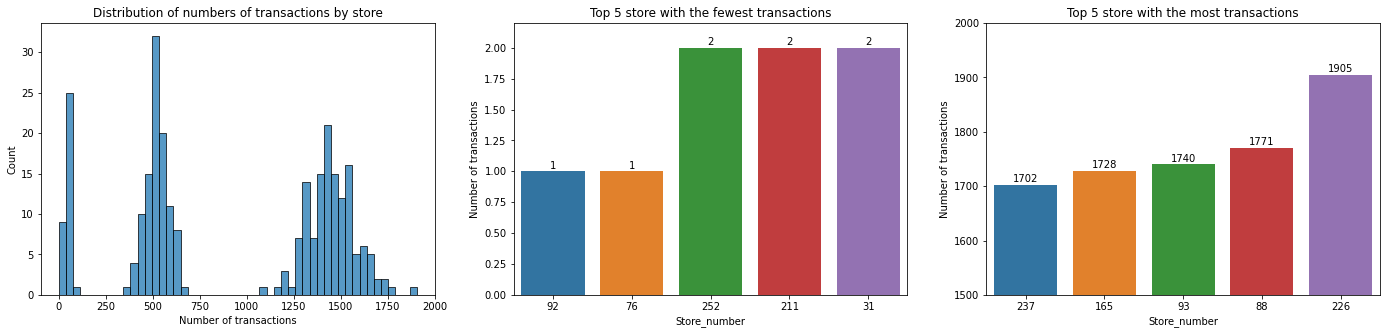

In [ ]:
#
store_transaction_lifestage = full[['Store_number','Transaction_id','LIFESTAGE']].drop_duplicates().reset_index(drop=True)
store_transaction = store_transaction_lifestage.groupby(['Store_number']).size().reset_index(name='Number of transactions')
#
fig = plt.figure(figsize=(24, 5))
# distribution of customers by store
fig.add_subplot(1, 3, 1)
ax = sns.histplot(data=store_transaction, x='Number of transactions', bins=50)
plt.title('Distribution of numbers of transactions by store')
# fewest cutomers
fig.add_subplot(1, 3, 2)
ax = sns.barplot(data=store_transaction, x='Store_number', y='Number of transactions', order=store_transaction.sort_values(by=['Number of transactions'])['Store_number'][:5])
add_value_to_barchart(ax=ax, gap_between_value_bar=0.02, if_value_int=True)
plt.title('Top 5 store with the fewest transactions')
# most customers
fig.add_subplot(1, 3, 3)
ax = sns.barplot(data=store_transaction, x='Store_number', y='Number of transactions', order=store_transaction.sort_values(by=['Number of transactions'])['Store_number'][-5:])
add_value_to_barchart(ax=ax, gap_between_value_bar=5, if_value_int=True)
plt.title('Top 5 store with the most transactions')
plt.ylim(1500,2000)
plt.show()

<font size=3> **Finding 2.15**
- <font size=3> **Customers of store 100 bought chips the most frequently, around 6.74 times per customets.**

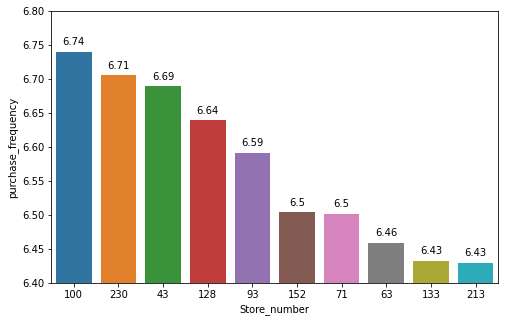

In [ ]:
purchase_fre = store_card.copy()
purchase_fre['purchase_frequency'] = store_transaction['Number of transactions']/purchase_fre['Number of customers']
fig = plt.figure(figsize=(8, 5))
ax= sns.barplot(data=purchase_fre, x='Store_number', y='purchase_frequency', order=purchase_fre.sort_values(by=['purchase_frequency'], ascending=False)['Store_number'][:10])
add_value_to_barchart(ax=ax, gap_between_value_bar=0.01)
plt.ylim(6.4,6.8)
plt.show()

<font size=3> **Finding 2.16**
- <font size=3> **The charts below display the top 5 stores with most customers from each segment.**

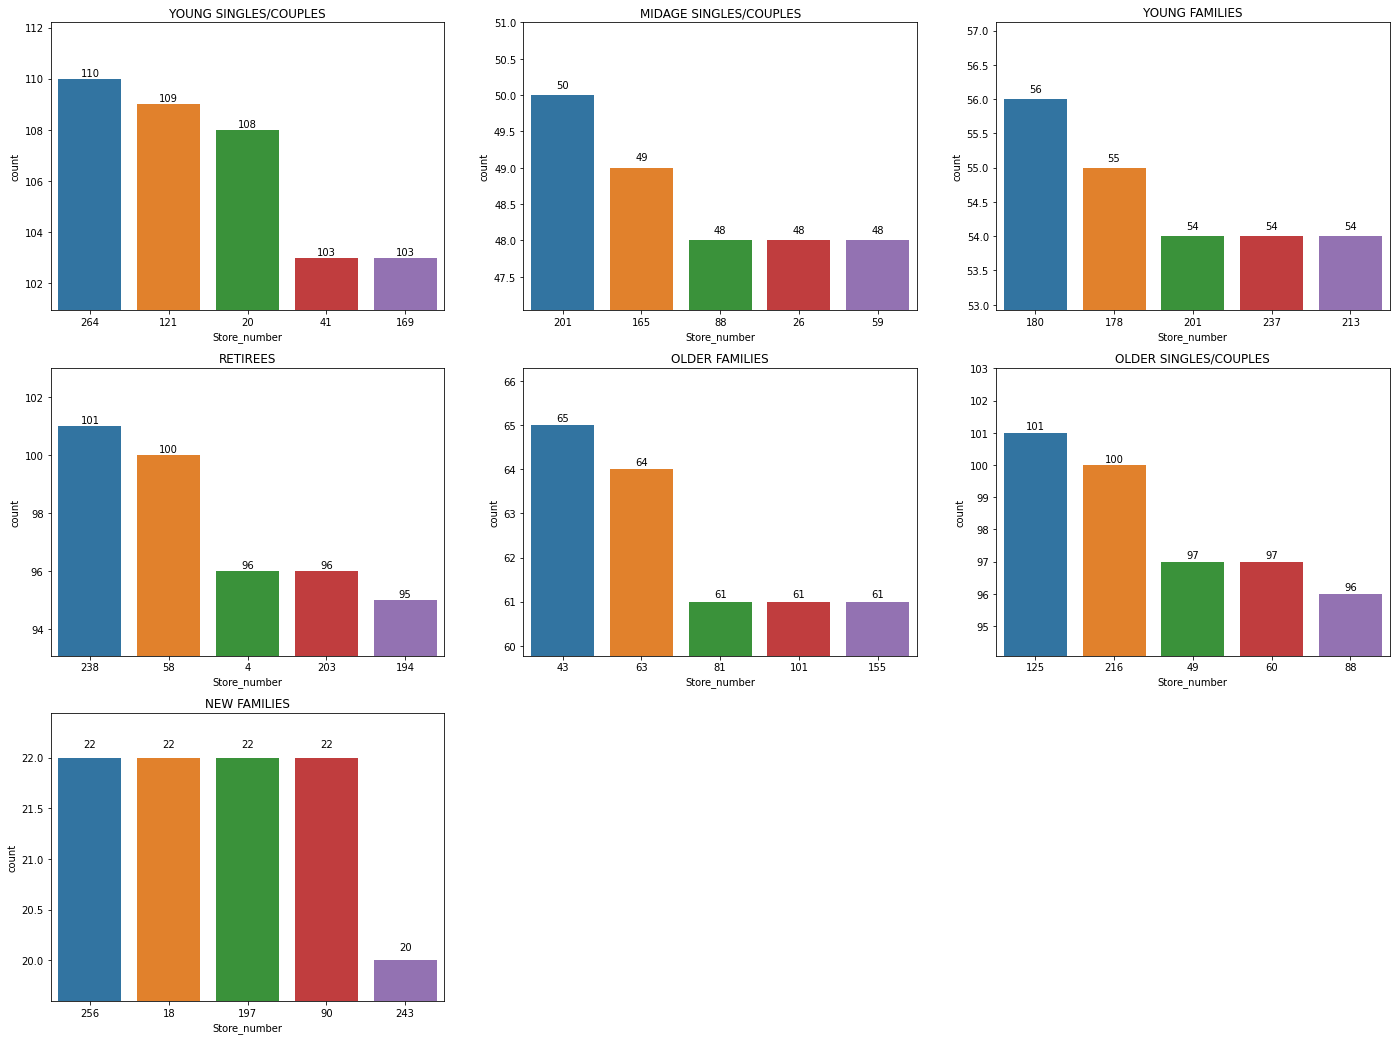

In [ ]:
#
fig = plt.figure(figsize=(24, 18))
plot_idx = 1
#
for i in store_card_lifestage['LIFESTAGE'].unique():
    fig.add_subplot(3, 3, plot_idx)
    plot_data = store_card_lifestage[store_card_lifestage['LIFESTAGE']==i].groupby(['Store_number']).size().reset_index(name='count').sort_values(by=['count'],ascending=False)[:5]
    ax = sns.barplot(data=plot_data, x='Store_number', y='count', order=plot_data['Store_number'])
    add_value_to_barchart(ax=ax, gap_between_value_bar=0.1, if_value_int=True)
    plt.title(i)
    plt.ylim(plot_data['count'].min()*0.98, plot_data['count'].max()*1.02)
    plot_idx+=1

<font size=3> **The charts below display the top 5 stores with highest proportion of each group of customers. (excluding stores having less than 200 customers)**

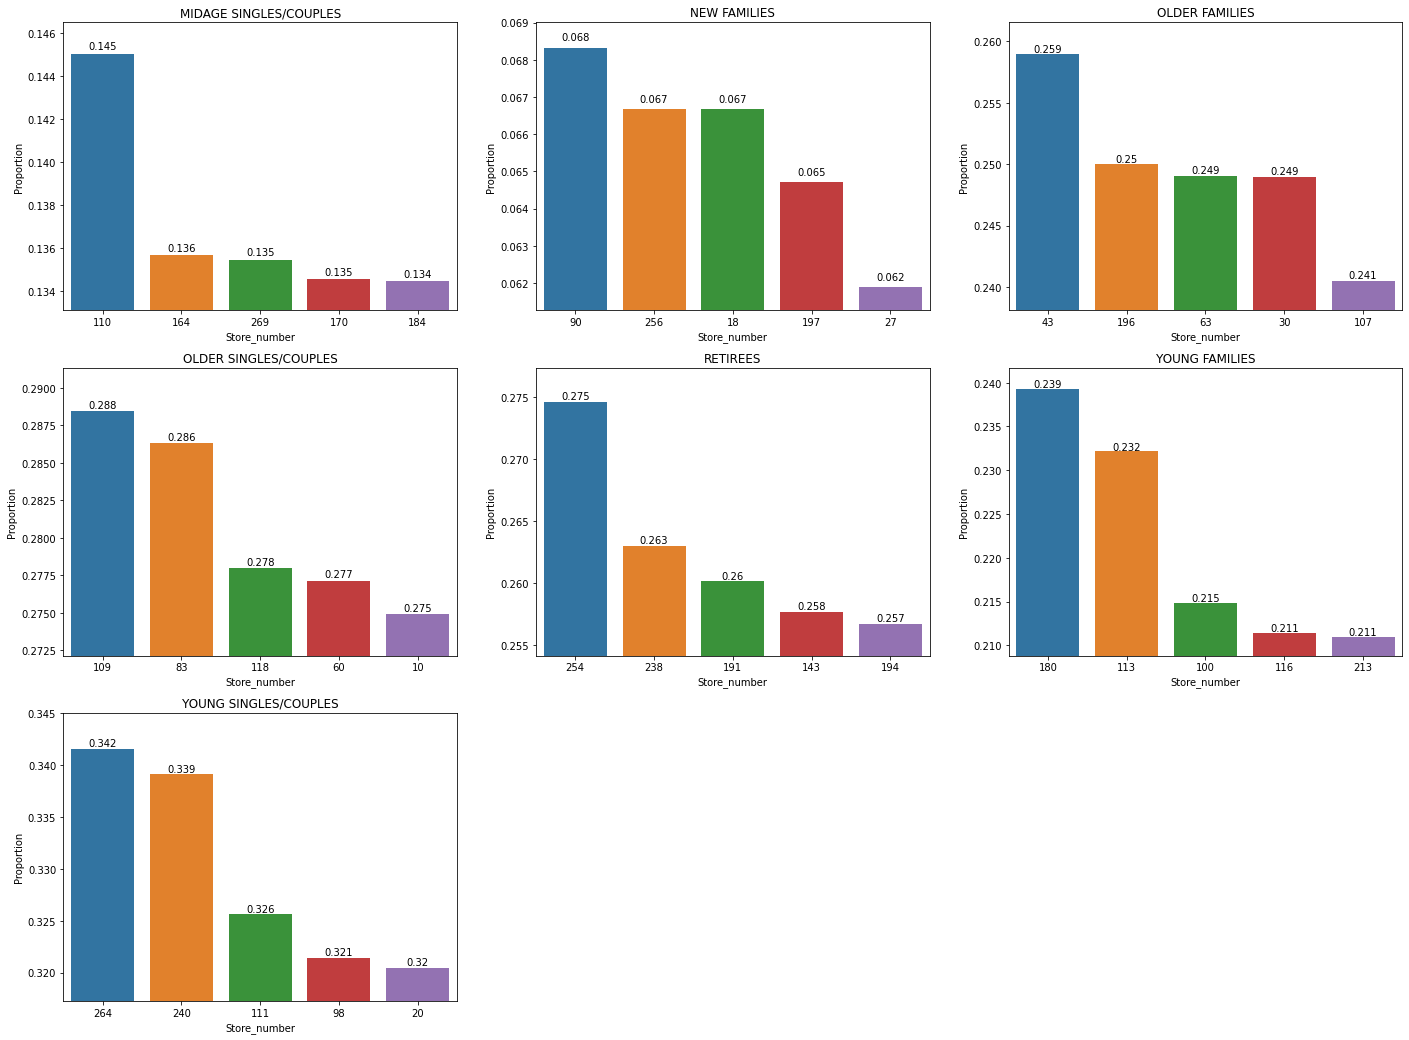

In [ ]:
#
big_stores = store_card[store_card['Number of customers']>=200]['Store_number'].values
store_card_lifestage_pivot = store_card_lifestage[store_card_lifestage['Store_number'].isin(big_stores)]
store_card_lifestage_pivot = store_card_lifestage_pivot.groupby(['Store_number','LIFESTAGE']).size().reset_index(name='count')
store_card_lifestage_pivot = store_card_lifestage_pivot.pivot(index='Store_number', columns='LIFESTAGE', values='count').fillna(0)
store_card_lifestage_pivot = store_card_lifestage_pivot.div(store_card_lifestage_pivot.sum(axis=1), axis=0)
#
fig = plt.figure(figsize=(24, 18))
plot_idx = 1
#
for i in store_card_lifestage_pivot.columns:
    fig.add_subplot(3, 3, plot_idx)
    plot_data = store_card_lifestage_pivot[[i]].sort_values(by=[i], ascending=False)[:5].reset_index()
    ax = sns.barplot(data=plot_data, x='Store_number', y=i, order=plot_data['Store_number'])
    plt.title(i)
    plt.ylabel('Proportion')
    plt.ylim(plot_data[i].min()*0.99, plot_data[i].max()*1.01)
    add_value_to_barchart(ax=ax, gap_between_value_bar=0.0002, value_decimal=3)
    plot_idx+=1

<font size=3> **Finding 2.17: PREMIUM_CUSTOMER has a strong impact on the total sales volume, but a week impact on the average sales volume per transcation and per customer.**
- <font size=3> **OLDER FAMILIES-Budget customers bought the most chips, NEW FAMILIES-Premium customers bought the fewest.**
- <font size=3> **OLDER FAMILIES-Mainstream customers bought the most chips per transaction, YOUNG SINGLES/COUPLES-Premium customers bought the fewest.**
- <font size=3> **OLDER FAMILIES-Mainstream customers bought the most chips per customer, YOUNG SINGLES/COUPLES-Budget customers bought the fewest.**

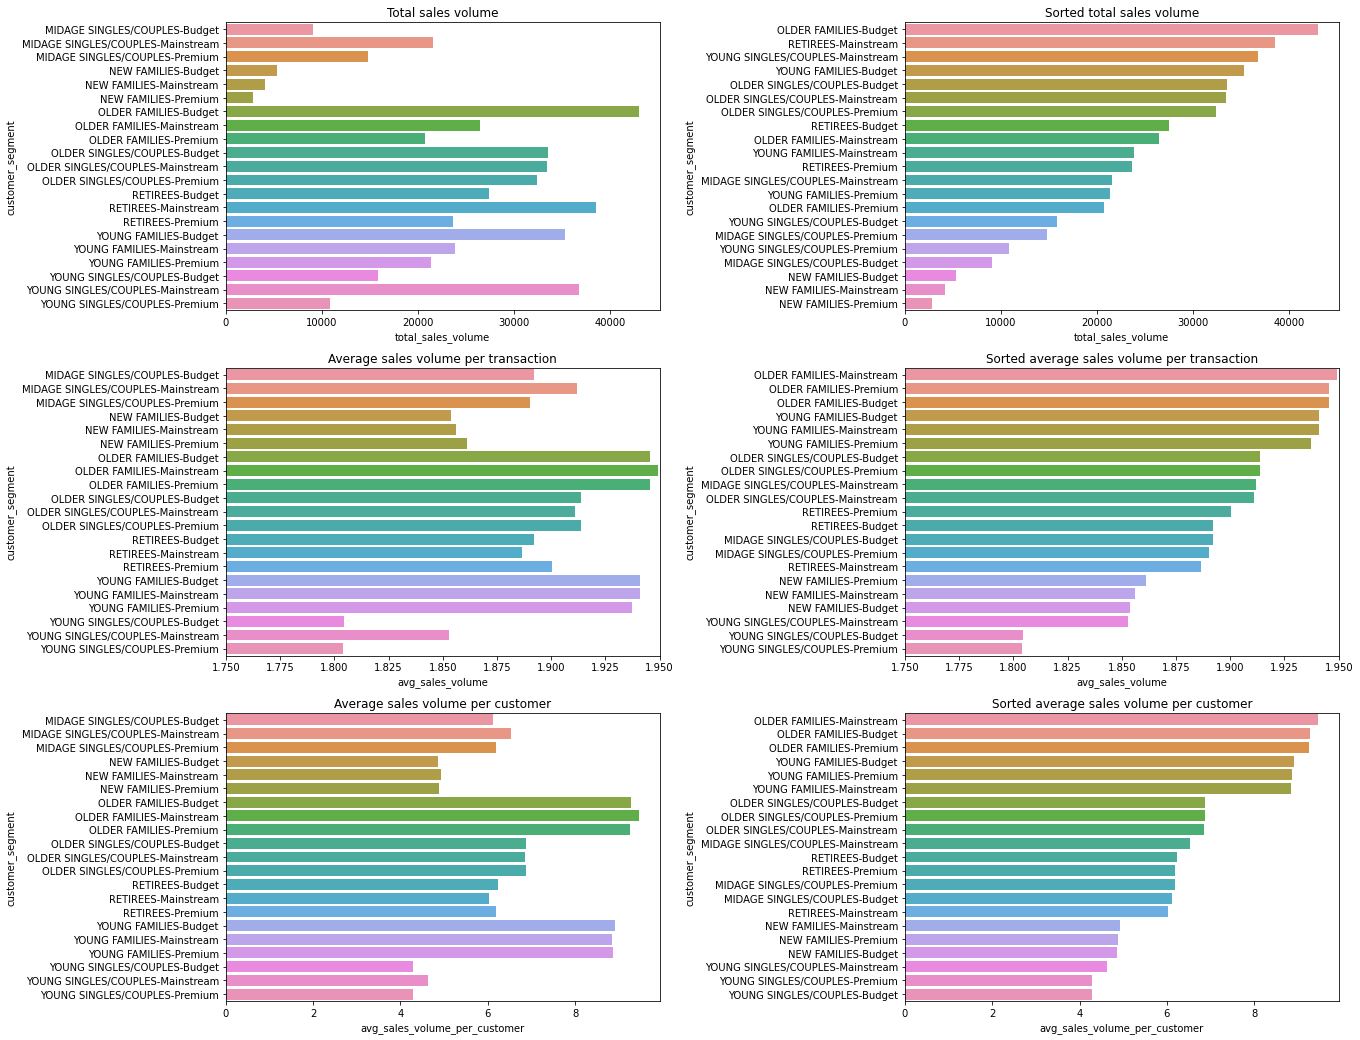

In [ ]:
#
segment_sales_volume = full.groupby(['customer_segment']).sum()['Product_quantity'].reset_index(name='total_sales_volume')
segment_sales_volume['avg_sales_volume'] = full.groupby(['customer_segment']).mean()['Product_quantity'].values
segment_sales_volume['avg_sales_volume_per_customer'] = full.groupby(['customer_segment','Card_number']).sum()['Product_quantity'].reset_index(name='total_sales_volume').groupby(['customer_segment']).mean()['total_sales_volume'].values
# create a figure
fig = plt.figure(figsize=(24, 18))
# total sales volume
ax1 = plt.subplot2grid((3, 12), (0, 0), colspan=4)
sns.barplot(ax=ax1, data=segment_sales_volume, y='customer_segment', x='total_sales_volume')
plt.title("Total sales volume")
# sort
ax2 = plt.subplot2grid((3, 12), (0, 6), colspan=4)
sns.barplot(ax=ax2, data=segment_sales_volume, y='customer_segment', x='total_sales_volume', order=segment_sales_volume.sort_values(by=['total_sales_volume'], ascending=False)['customer_segment'])
plt.title("Sorted total sales volume")
# average sales volume per transaction
ax3 = plt.subplot2grid((3, 12), (1, 0), colspan=4)
sns.barplot(ax=ax3, data=segment_sales_volume, y='customer_segment', x='avg_sales_volume')
plt.title("Average sales volume per transaction")
plt.xlim((1.75,1.95))
# sort
ax4 = plt.subplot2grid((3, 12), (1, 6), colspan=4)
sns.barplot(ax=ax4, data=segment_sales_volume, y='customer_segment', x='avg_sales_volume', order=segment_sales_volume.sort_values(by=['avg_sales_volume'], ascending=False)['customer_segment'])
plt.title("Sorted average sales volume per transaction")
plt.xlim((1.75,1.95))
# average sales volume per customer
ax5 = plt.subplot2grid((3, 12), (2, 0), colspan=4)
sns.barplot(ax=ax5, data=segment_sales_volume, y='customer_segment', x='avg_sales_volume_per_customer')
plt.title("Average sales volume per customer")
# sort
ax6= plt.subplot2grid((3, 12), (2, 6), colspan=4)
sns.barplot(ax=ax6, data=segment_sales_volume, y='customer_segment', x='avg_sales_volume_per_customer', order=segment_sales_volume.sort_values(by=['avg_sales_volume_per_customer'], ascending=False)['customer_segment'])
plt.title("Sorted average sales volume per customer")
plt.show()

<font size=3> **Finding 2.18 PREMIUM_CUSTOMER has an strong impact on the total sales and the average sales per transaction, but a weak impact on the average sales per customer.**
- <font size=3> **OLDER FAMILIES-Budget customers brought the highest sales revenue, NEW FAMILIES-Premium customers brought the lowest.**
- <font size=3> **MIDAGE SINGLE/COUPLES-Mainstream customers brought the highest sales revenue per transaction, YOUNG SINGLES/COUPLES-Budget customers bought the lowest.**
- <font size=3> **OLDER FAMILIES-Mainstream customers brought the highest sales revenue per customer, YOUNG SINGLES/COUPLES-Budget customers bought the lowest.**

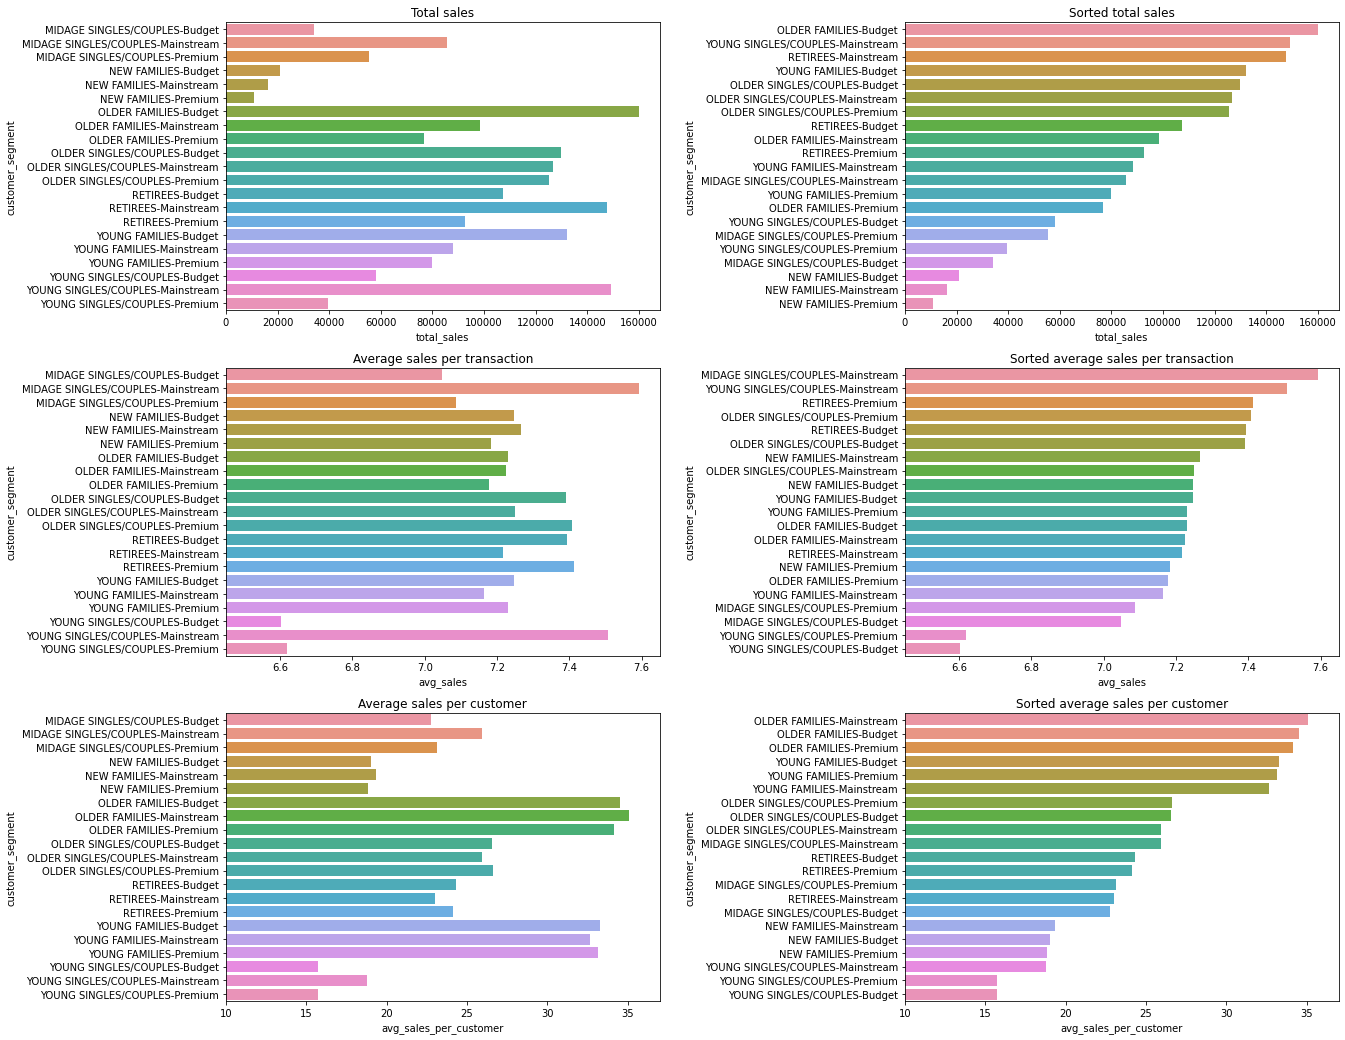

In [ ]:
#
segment_sales = full.groupby(['customer_segment']).sum()['Total_sales'].reset_index(name='total_sales')
segment_sales['avg_sales'] = full.groupby(['customer_segment']).mean()['Total_sales'].values
segment_sales['avg_sales_per_customer'] = full.groupby(['customer_segment','Card_number']).sum()['Total_sales'].reset_index(name='total_sales').groupby(['customer_segment']).mean()['total_sales'].values
# create a figure
fig = plt.figure(figsize=(24, 18))
# total sales
ax1 = plt.subplot2grid((3, 12), (0, 0), colspan=4)
sns.barplot(ax=ax1, data=segment_sales, y='customer_segment', x='total_sales')
plt.title("Total sales")
# sort
ax2 = plt.subplot2grid((3, 12), (0, 6), colspan=4)
sns.barplot(ax=ax2, data=segment_sales, y='customer_segment', x='total_sales', order=segment_sales.sort_values(by=['total_sales'], ascending=False)['customer_segment'])
plt.title("Sorted total sales")
# average sales volume per transaction
ax3 = plt.subplot2grid((3, 12), (1, 0), colspan=4)
sns.barplot(ax=ax3, data=segment_sales, y='customer_segment', x='avg_sales')
plt.title("Average sales per transaction")
plt.xlim((6.45,7.65))
# sort
ax4 = plt.subplot2grid((3, 12), (1, 6), colspan=4)
sns.barplot(ax=ax4, data=segment_sales, y='customer_segment', x='avg_sales', order=segment_sales.sort_values(by=['avg_sales'], ascending=False)['customer_segment'])
plt.title("Sorted average sales per transaction")
plt.xlim((6.45,7.65))
# average sales per customer
ax5 = plt.subplot2grid((3, 12), (2, 0), colspan=4)
sns.barplot(ax=ax5, data=segment_sales, y='customer_segment', x='avg_sales_per_customer')
plt.title("Average sales per customer")
plt.xlim((10,37))
# sort
ax6= plt.subplot2grid((3, 12), (2, 6), colspan=4)
sns.barplot(ax=ax6, data=segment_sales, y='customer_segment', x='avg_sales_per_customer', order=segment_sales.sort_values(by=['avg_sales_per_customer'], ascending=False)['customer_segment'])
plt.title("Sorted average sales per customer")
plt.xlim((10,37))
plt.show()

<font size=3> **Finding 2.19: PREMIUM_CUSTOMER has an impact on the average product price.**
- <font size=3> **YOUNG SINGLES/COUPLES-Mainstream customers tended to buy more expensive chips.**
- <font size=3> **YOUNG SINGLES/COUPLES-Budget customers tended to buy cheaper chips.**

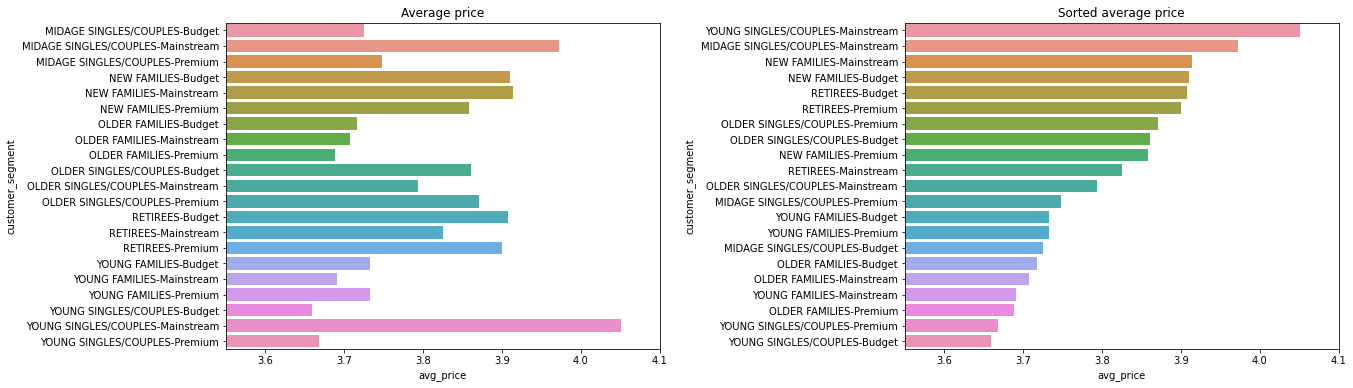

In [ ]:
#
segment_price = segment_sales.merge(segment_sales_volume, on=['customer_segment'], how='left')
segment_price['avg_price'] = segment_price['total_sales']/segment_price['total_sales_volume']
#
fig = plt.figure(figsize=(24, 6))
# average price
ax1 = plt.subplot2grid((1, 12), (0, 0), colspan=4)
sns.barplot(ax=ax1, data=segment_price, y='customer_segment', x='avg_price')
plt.title("Average price")
plt.xlim(3.55,4.1)
# sort
ax2 = plt.subplot2grid((1, 12), (0, 6), colspan=4)
sns.barplot(ax=ax2, data=segment_price, y='customer_segment', x='avg_price', order=segment_price.sort_values(by=['avg_price'], ascending=False)['customer_segment'])
plt.title("Sorted average price")
plt.xlim(3.55,4.1)
plt.show()

Conclusion:                                                                         
    Let’s recap what we’ve found!
Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream
- retirees shoppers. We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers. Mainstream, midage and young singles and
couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour.
We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips
compared to the rest of the population. The Category Manager may want to increase the category’s performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments
where young singles and couples frequent more often to increase visibilty and impulse behaviour.
Quantium can help the Category Manager with recommendations of where these segments are and further
help them with measuring the impact of the changed placement. We’ll work on measuring the impact of
trials in the next task and putting all these together in the third task.